In [1]:
# Importando bibliotecas
import os
import re
import warnings
import numpy as np
import pandas as pd
import altair as alt
import pyomo.environ as pyo
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from rapidfuzz import process
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

#pd.reset_option("display.max_rows")

# Dados

Os dados utilizados na pesquisa e resultado de informa√ß√µes, de origens publica e restrita tendo como fontes o portal da [**Portal da Tranpar√™ncia do TJBA**](https://www.tjba.jus.br/transparencia/), [**DataJude**](https://www.cnj.jus.br/sistemas/datajud/) e PJe em parceria com o TJBA.

Diret√≥dio do projeto onde est√£o os dados:

```
dados
‚îú‚îÄ‚îÄ DADOS_TJBA_PG.parquet - Arquivo gerado pelo Apache Hop no cruzaemnto de dados do 1¬∫ Grau
‚îî‚îÄ‚îÄ MEMBROS-DO-TJBA-E-AGENTES-PUBLICOS.csv - Arquivo do PT com lista de magistrados e lota√ß√£o
```

## Dados de Magistrados - Portal da Transpar√™ncia
Esses dados podem demosntrar quantos magistrados exitem por vara.

In [2]:
# Inportando dados de magistrados do PT
df_magistrados = pd.read_csv('../../dados/MEMBROS_E_AGENTES_PUBLICOS_JUL2025.csv', sep=';')
df_magistrados = df_magistrados[df_magistrados['Cargo'].str.startswith('JUIZ', na=False)]

df_magistrados.head()

Nome  Matr√≠cula Funcional  \
7                    ABRAAO BARRETO CORDEIRO              9679782   
25               ADALBERTO LIMA BORGES FILHO              9698345   
69           ADERALDO DE MORAIS LEITE JUNIOR              9679871   
73  ADIANE JAQUELINE NEVES DA SILVA OLIVEIRA              9679812   
74                    ADIDA ALVES DOS SANTOS              8098654   

              Cargo Fun√ß√£o de Confian√ßa/ Cargo em Comiss√£o  \
7   JUIZ DE DIREITO                                    NaN   
25  JUIZ DE DIREITO                                    NaN   
69  JUIZ DE DIREITO                                    NaN   
73  JUIZ DE DIREITO                                    NaN   
74  JUIZ DE DIREITO                                    NaN   

                                        Lota√ß√£o Ato de Provimento  \
7                VARA CRIM JURI EXEC PENAIS MEN          PORT S/N   
25                             JURISDICAO PLENA          PORT S/N   
69                             JURISDICAO PLENA          PORT S/N   
73  1¬™  VARA DOS SISTEMA DOS JUIZADOS ESPECIAIS          PORT S/N   
74             2¬™ VARA DA  INFANCIA E JUVENTUDE          PORT S/N   

   Data de Publica√ß√£o  
7          16/09/2013  
25         06/10/2021  
69         16/09/2013  
73         16/09/2013  
74         01/12/2004

In [3]:
df_magistrados.shape

(621, 7)

In [4]:
df_magistrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 7 to 8846
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Nome                                    621 non-null    object
 1   Matr√≠cula Funcional                     621 non-null    int64 
 2   Cargo                                   621 non-null    object
 3   Fun√ß√£o de Confian√ßa/ Cargo em Comiss√£o  0 non-null      object
 4   Lota√ß√£o                                 621 non-null    object
 5   Ato de Provimento                       621 non-null    object
 6   Data de Publica√ß√£o                      621 non-null    object
dtypes: int64(1), object(6)
memory usage: 38.8+ KB


In [5]:
# Contagens de Ju√≠zes
df_magistrados.Cargo.value_counts()

Cargo
JUIZ DE DIREITO                                      544
JUIZ SUBSTITUTO                                       56
JUIZ SUBSTITUTO DE SEGUNDO GRAU - ENTRANCIA FINAL     21
Name: count, dtype: int64

In [6]:
# Pesquisa por magistrado
df_magistrados[df_magistrados['Nome'] == 'ULYSSES MAYNARD SALGADO']

Nome  Matr√≠cula Funcional            Cargo  \
8430  ULYSSES MAYNARD SALGADO              8088900  JUIZ DE DIREITO   

     Fun√ß√£o de Confian√ßa/ Cargo em Comiss√£o                  Lota√ß√£o  \
8430                                    NaN  1A VARA FAZENDA PUBLICA   

     Ato de Provimento Data de Publica√ß√£o  
8430          PORT S/N         23/12/2002

In [7]:
# Contagem de Lota√ß√£o
df_magistrados_g = df_magistrados.groupby('Lota√ß√£o').agg(quant=('Lota√ß√£o', 'count'))

In [8]:
df_magistrados_g

quant
Lota√ß√£o                                                  
 1¬™ VARA CRIM JURI EXEC PENAIS                          1
 VARA  EXEC. PENAIS E MEDIDAS ALTERNATIVAS              1
10¬™ VARA CIVEL                                          1
10¬™ VARA DE FAMILIA                                     1
10¬™ VARA DE RELACOES DE CONSUMO                         1
...                                                   ...
VARA ESP CRIM INFAN JUVEN                               1
VARA FEITOS  RELATIVOS REL DE CONSUMO CIVEIS E COM      1
VARA FEITOS RELATIVOS  REL DE CONSUMO CIVEIS E COM      1
VARA FEITOS RELATIVOS REL DE CONSUMO CIVEIS COM         1
VARA FEITOS RELATIVOS REL DE CONSUMO CIVEIS E COM      38

[320 rows x 1 columns]

In [9]:
# Vara com maior n√∫mero de ju√≠zes atuantes
df_magistrados_g[df_magistrados_g['quant'] == df_magistrados_g['quant'].max()]

quant
Lota√ß√£o                
JURISDICAO PLENA     88

## Cruzamento dos Dados

Nessa fase precisamos cruzar alguns dados, apesar de termos fontes como **CNJ(DataJUD)**, algumas informa√ß√µes s√£o mais espec√≠ficas e precisamos cruzar essas informa√ß√µes com o TJBA. Nessa primeira etapa devido ao volume e acomplexidade, foi utilizado a ferramenta de ETL [**Apache Hop**](https://hop.apache.org/), para o cruzamento, an√°lises e um tratamento inicial. O artefado final gerado nessa etapa ser√° um arquivo parquet, que usaremos como principal fonte de dados para o modelo.

<p align="center">
    <img width="850" height="250" src="../../img/001.png">
</p>

## Tratamento dos Dados

Aqui vamos trabalhar com os dados gerado na etapa de cruzemnto, realizando alguns tratamentos e adequando os dados;

*	Selecionar as melhores features (colunas).
*	Remover features (colunas) dos df's.
*	Verificar valores ausentes que possam impactar. 
*	Verificar qual fonte dos dados relacionado a sistemas vamos utilizar.
*	Trabalhar na quest√£o dos magistrados.
*	Etc...






### Tratando Dados do TJBA

In [10]:
# Verificando eschema do arquivo parquet gerado
table = pq.read_table("../../dados/DADOS_TJBA_PG.parquet")
print(table.schema)

pje_processo: string
vm_processo: string
vm_dt_recebimento: timestamp[ms, tz=UTC]
vm_dt_movimento: timestamp[ms, tz=UTC]
vm_cod_cnj_comarca: int64
vm_mapa_comarca: int64
vm_cod_comarca: int64
vm_comarca: string
pje_id_jurisdicao: int64
pje_ds_jurisdicao: string
vm_mapa_vara: int64
vm_cod_vara: int64
vm_cod_cnj_vara: int64
pje_id_orgao_julgador: int64
pje_nr_vara: int64
vm_vara: string
pje_ds_orgao_julgador: string
pje_cd_classe_judicial: string
vm_cod_cls_cnj: int64
vm_classe: string
pje_ds_classe_judicial: string
pje_ds_natureza: string
pje_vl_peso: int64
pje_cd_assunto_principal: string
pje_ds_assunto_principal: string
vm_cod_mov_cnj: int64
vm_movimento: string
pje_id_competencia: int64
pje_ds_competencia: string
vm_competencia: string
vm_localizacao: string
vm_tp_proc: string
pje_id_orgao_julgador_cargo: int64
pje_ds_orgao_julgador_cargo: string
vm_cod_cnj_magistrado: int64
vm_mapa_magistrado: int64
vm_cod_magistrado: string
vm_magistrado: string
vm_consulta: string
vm_situacao: str

In [11]:
# Importando arquivo parquet gerado pelo Apache Hop no Pandas
df_tjba = pd.read_parquet('../../dados/DADOS_TJBA_PG.parquet', engine="pyarrow", use_pandas_metadata=False)

# Conver timestamp para datetime
#df["cnj_dt_referencia"] = df["cnj_dt_referencia"].dt.tz_convert(None)
#df["vm_dt_recebimento"] = df["vm_dt_recebimento"].dt.tz_convert(None)
#df["vm_dt_movimento"] = df["vm_dt_movimento"].dt.tz_convert(None)

df_tjba.shape

(11715246, 50)

In [12]:
df_tjba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11715246 entries, 0 to 11715245
Data columns (total 50 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   pje_processo                 object             
 1   vm_processo                  object             
 2   vm_dt_recebimento            datetime64[ms, UTC]
 3   vm_dt_movimento              datetime64[ms, UTC]
 4   vm_cod_cnj_comarca           int64              
 5   vm_mapa_comarca              int64              
 6   vm_cod_comarca               int64              
 7   vm_comarca                   object             
 8   pje_id_jurisdicao            float64            
 9   pje_ds_jurisdicao            object             
 10  vm_mapa_vara                 int64              
 11  vm_cod_vara                  int64              
 12  vm_cod_cnj_vara              int64              
 13  pje_id_orgao_julgador        float64            
 14  pje_nr_vara     

In [13]:
df_tjba.head()

pje_processo                vm_processo  \
0  8003619-75.2022.8.05.0271  8003619-75.2022.8.05.0271   
1  8003068-15.2022.8.05.0039  8003068-15.2022.8.05.0039   
2  0088391-11.2003.8.05.0001  0088391-11.2003.8.05.0001   
3  0000087-73.2019.8.05.0066  0000087-73.2019.8.05.0066   
4  8055437-37.2021.8.05.0001  8055437-37.2021.8.05.0001   

          vm_dt_recebimento           vm_dt_movimento  vm_cod_cnj_comarca  \
0 2022-09-19 14:02:01+00:00 2024-08-26 12:47:34+00:00                5359   
1 2022-02-06 18:58:24+00:00 2024-09-19 15:03:05+00:00                 903   
2 2003-07-18 13:10:09+00:00 2025-07-18 22:24:10+00:00                4278   
3 2019-03-18 18:20:00+00:00 2025-07-09 17:53:34+00:00                1337   
4 2021-05-28 13:47:59+00:00 2025-05-30 17:27:43+00:00                4278   

   vm_mapa_comarca  vm_cod_comarca vm_comarca  pje_id_jurisdicao  \
0              403            1255    VALENCA              255.0   
1               68             115   CAMACARI               15.0   
2              334              18   SALVADOR                8.0   
3              103            1165   CONDEUBA              165.0   
4              334              18   SALVADOR                8.0   

                 pje_ds_jurisdicao  vm_mapa_vara  vm_cod_vara  \
0                          VALEN√áA          1642        11534   
1                         CAMA√áARI          2004        11453   
2  SALVADOR - REGI√ÉO METROPOLITANA          4202       111452   
3                         CONDE√öBA           273        11754   
4  SALVADOR - REGI√ÉO METROPOLITANA           716        11553   

   vm_cod_cnj_vara  pje_id_orgao_julgador  pje_nr_vara  \
0            50076                  534.0       1248.0   
1            79440                  453.0         45.0   
2            90461                 1452.0         15.0   
3             5130                  754.0        314.0   
4            17167                  553.0        923.0   

                                                vm_vara  \
0  2¬™ VARA DE FEITOS DE REL DE CONS. C√çVEL E COMERCIAIS   
1                            2¬™ VARA DA FAZENDA P√öBLICA   
2                           15¬™ VARA DA FAZENDA P√öBLICA   
3                                 VARA JURISDI√á√ÉO PLENA   
4                             6¬™ VARA C√çVEL E COMERCIAL   

                                                             pje_ds_orgao_julgador  \
0  2¬™ V DOS FEITOS DE REL. DE CONS. C√çVEIS COM. FAZ. PUB. E ACID. TRAB. DE VALEN√áA   
1                                              2¬™ V DE FAZENDA PUBLICA DE CAMA√áARI   
2                                             15¬™ V DA FAZENDA P√öBLICA DE SALVADOR   
3                                                        VARA CRIMINAL DE CONDE√öBA   
4                                               6¬™ V C√çVEL E COMERCIAL DE SALVADOR   

  pje_cd_classe_judicial  vm_cod_cls_cnj                           vm_classe  \
0                     65              65                  ACAO CIVIL PUBLICA   
1                   1116            1116                     EXECUCAO FISCAL   
2                   1116            1116                     EXECUCAO FISCAL   
3                    283             283  ACAO PENAL  PROCEDIMENTO ORDINARIO   
4                      7               7            PROCEDIMENTO COMUM CIVEL   

                pje_ds_classe_judicial pje_ds_natureza  pje_vl_peso  \
0                   A√á√ÉO CIVIL P√öBLICA    CONHECIMENTO          2.0   
1                      EXECU√á√ÉO FISCAL        EXECU√ß√£O          2.0   
2                      EXECU√á√ÉO FISCAL        EXECU√ß√£O          2.0   
3  A√á√ÉO PENAL - PROCEDIMENTO ORDIN√ÅRIO    CONHECIMENTO          2.0   
4             PROCEDIMENTO COMUM C√çVEL    CONHECIMENTO          2.0   

  pje_cd_assunto_principal        pje_ds_assunto_principal  vm_cod_mov_cnj  \
0                    10113                           Flora           11010   
1                     6017  D√≠vida Ativa (Execu√ß√£o Fiscal)            

In [14]:
# Removendo fetures
df_tjba.drop([
    'pje_processo', 'vm_dt_recebimento', 'vm_cod_cnj_comarca', 'vm_mapa_comarca', 'pje_id_jurisdicao', 
    'pje_ds_jurisdicao', 'vm_mapa_vara', 'vm_cod_cnj_vara', 'pje_id_orgao_julgador', 'pje_nr_vara', 
    'pje_ds_orgao_julgador', 'pje_cd_classe_judicial', 'vm_cod_cls_cnj', 'vm_classe', 'pje_ds_classe_judicial', 
    'pje_ds_natureza', 'pje_vl_peso', 'pje_cd_assunto_principal', 'pje_ds_assunto_principal', 'vm_cod_mov_cnj', 
    'pje_ds_competencia', 'vm_localizacao', 'vm_tp_proc', 'pje_id_orgao_julgador_cargo', 'pje_ds_orgao_julgador_cargo', 
    'vm_cod_cnj_magistrado', 'vm_cod_magistrado', 'vm_entrancia', 'vm_compl_mov',  'vm_tempo_tramitacao', 
    'vm_prioridade', 'vm_ds_prioridade','pje_vl_peso_prioridade', 'vm_concluso', 'vm_num_ativo'
], axis=1, inplace=True)

In [15]:
# Colocando dados em letras mai√∫sculas
#df_tjba['pje_ds_natureza'] = df_tjba['pje_ds_natureza'].str.upper()

# Retirando o timestamp
#df_tjba['vm_dt_recebimento'] = df_tjba['vm_dt_recebimento'].dt.date
#df_tjba['vm_dt_recebimento'] = pd.to_datetime(df_tjba['vm_dt_recebimento']) # Erro 1001-10-30, at position 93295

#df_tjba['vm_dt_movimento'] = df_tjba['vm_dt_movimento'].dt.date
#df_tjba['vm_dt_movimento'] = pd.to_datetime(df_tjba['vm_dt_movimento'])

In [16]:
# Percorre todas as colunas do df_tjba do tipo object, retirando espa√ßos laterais e mais de um espa√ßos entre palavras
for col in df_tjba.select_dtypes(include=['object']).columns:
    df_tjba[col] = (
        df_tjba[col].str.strip().str.replace(r'\s+', ' ', regex=True)
    )

In [17]:
df_tjba.head()

vm_processo           vm_dt_movimento  vm_cod_comarca  \
0  8003619-75.2022.8.05.0271 2024-08-26 12:47:34+00:00            1255   
1  8003068-15.2022.8.05.0039 2024-09-19 15:03:05+00:00             115   
2  0088391-11.2003.8.05.0001 2025-07-18 22:24:10+00:00              18   
3  0000087-73.2019.8.05.0066 2025-07-09 17:53:34+00:00            1165   
4  8055437-37.2021.8.05.0001 2025-05-30 17:27:43+00:00              18   

  vm_comarca  vm_cod_vara  \
0    VALENCA        11534   
1   CAMACARI        11453   
2   SALVADOR       111452   
3   CONDEUBA        11754   
4   SALVADOR        11553   

                                                vm_vara  \
0  2¬™ VARA DE FEITOS DE REL DE CONS. C√çVEL E COMERCIAIS   
1                            2¬™ VARA DA FAZENDA P√öBLICA   
2                           15¬™ VARA DA FAZENDA P√öBLICA   
3                                 VARA JURISDI√á√ÉO PLENA   
4                             6¬™ VARA C√çVEL E COMERCIAL   

                                            vm_movimento  pje_id_competencia  \
0                  PROFERIDO DESPACHO DE MERO EXPEDIENTE                 9.0   
1  EXTINTO O PROCESSO POR AUSENCIA DAS CONDICOES DA ACAO                 6.0   
2                  PROFERIDO DESPACHO DE MERO EXPEDIENTE                 9.0   
3                  PROFERIDO DESPACHO DE MERO EXPEDIENTE                53.0   
4                  PROFERIDO DESPACHO DE MERO EXPEDIENTE                12.0   

                         vm_competencia  vm_mapa_magistrado  \
0  FAZENDA PUBLICA ATOS ADMINISTRATIVOS               378.0   
1              FAZENDA PUBLICA TRIBUTOS               166.0   
2  FAZENDA PUBLICA ATOS ADMINISTRATIVOS               161.0   
3                                 CRIME              1492.0   
4                                 CIVEL               750.0   

                               vm_magistrado vm_consulta   vm_situacao  \
0                   LEONARDO RULIAN CUSTODIO    DESPACHO  EM ANDAMENTO   
1                         DANIEL LIMA FALCAO  JULGAMENTO       BAIXADO   
2           CRISTIANE MENEZES SANTOS BARRETO    DESPACHO  EM ANDAMENTO   
3                   CARLOS TIAGO SILVA ADAES    DESPACHO  EM ANDAMENTO   
4  CARLOS CARVALHO RAMOS DE CERQUEIRA JUNIOR    DESPACHO  EM ANDAMENTO   

   pje_vl_peso_processual vm_sistema  
0                     4.0      PJEPG  
1                     4.0      PJEPG  
2                     4.0      PJEPG  
3                     4.0      PJEPG  
4                     4.0      PJEPG

In [18]:
df_tjba.shape

(11715246, 15)

Um processo que recebeu peso 2 e foi julgado 5 vezes pelo mesmo magistrado, eu devo contabilizar 10 ou somente 2?

*	**Evitar Superestima√ß√£o da Produtividade:** Se um processo de peso 2 √© julgado 5 vezes pelo mesmo magistrado, e contabiliza 10 pontos (5 x 2), estaria inflando a produtividade desse juiz. O processo, em sua ess√™ncia, ainda √© um √∫nico processo de peso 2. O trabalho adicional nas 4 senten√ßas subsequentes √© parte do esfor√ßo para finalizar aquele processo, mas n√£o representa 5 processos distintos de peso 2.

*	**Coer√™ncia com o Conceito de Peso:** O peso √© atribu√≠do ao processo como um todo, refletindo sua complexidade intr√≠nseca. Ele n√£o √© um valor que se multiplica a cada intera√ß√£o, mas sim um valor que √© "consumido" quando o processo √© finalmente resolvido.

In [ ]:
# Seleciona dados de 2024, retirando ACERVO, DISTRIBUIDO e BAIXADO
df_processos = df_tjba[(~ df_tjba['vm_consulta'].isin(['ACERVO', 'DISTRIBUIDO', 'BAIXADO'])) & 
                    (df_tjba['vm_dt_movimento'].dt.year == 2024) & 
                    (df_tjba['vm_sistema'] == 'PJEPG')].drop_duplicates(['vm_processo', 'vm_mapa_magistrado'])

# Convertendo float para int
df_processos['pje_vl_peso_processual'] = df_processos['pje_vl_peso_processual'].astype('Int64')
df_processos['vm_mapa_magistrado'] = df_processos['vm_mapa_magistrado'].astype('Int64')

# Criando campo para identifica√ß√£o dos magistrados
df_processos['juiz_str'] = 'JUIZ_' + df_processos['vm_mapa_magistrado'].astype(str)
df_processos['vara_str'] = 'VARA_' + df_processos['vm_cod_vara'].astype(str)

In [20]:
df_processos.shape

(2873627, 17)

### Tratando Dados do Portal da Transpar√™ncia

In [21]:
# Alguns nomes do df de cadastro (PT) n√£o batem com o do TJBA, ajustando o cadastro por similaridade
df_magistrados['vm_nome'] = np.nan
nomes_mov = df_tjba['vm_magistrado'].dropna().unique()

for i, row in df_magistrados.iterrows():
    nome_cadastro = row['Nome']
    match, score, idx = process.extractOne(nome_cadastro, nomes_mov)
    
    if score > 85:  # limiar de confian√ßa
        df_magistrados.at[i, 'vm_nome'] = match

In [22]:
df_magistrados.head()

Nome  Matr√≠cula Funcional  \
7                    ABRAAO BARRETO CORDEIRO              9679782   
25               ADALBERTO LIMA BORGES FILHO              9698345   
69           ADERALDO DE MORAIS LEITE JUNIOR              9679871   
73  ADIANE JAQUELINE NEVES DA SILVA OLIVEIRA              9679812   
74                    ADIDA ALVES DOS SANTOS              8098654   

              Cargo Fun√ß√£o de Confian√ßa/ Cargo em Comiss√£o  \
7   JUIZ DE DIREITO                                    NaN   
25  JUIZ DE DIREITO                                    NaN   
69  JUIZ DE DIREITO                                    NaN   
73  JUIZ DE DIREITO                                    NaN   
74  JUIZ DE DIREITO                                    NaN   

                                        Lota√ß√£o Ato de Provimento  \
7                VARA CRIM JURI EXEC PENAIS MEN          PORT S/N   
25                             JURISDICAO PLENA          PORT S/N   
69                             JURISDICAO PLENA          PORT S/N   
73  1¬™  VARA DOS SISTEMA DOS JUIZADOS ESPECIAIS          PORT S/N   
74             2¬™ VARA DA  INFANCIA E JUVENTUDE          PORT S/N   

   Data de Publica√ß√£o                          vm_nome  
7          16/09/2013          ABRAAO BARRETO CORDEIRO  
25         06/10/2021      ADALBERTO LIMA BORGES FILHO  
69         16/09/2013  ADERALDO DE MORAIS LEITE JUNIOR  
73         16/09/2013  ADIANE JAQUELINE NEVES DA SILVA  
74         01/12/2004           ADIDA ALVES DOS SANTOS

In [23]:
# Verificando se todos os nomes foram preenchidos
df_magistrados[df_magistrados['vm_nome'].isna()]

Empty DataFrame
Columns: [Nome, Matr√≠cula Funcional, Cargo, Fun√ß√£o de Confian√ßa/ Cargo em Comiss√£o, Lota√ß√£o, Ato de Provimento, Data de Publica√ß√£o, vm_nome]
Index: []

# An√°lise Explorat√≥ria

In [24]:
# Paleta de cores.
azul1, azul2, azul3= '#95adbe', '#574f7d', '#3c2a4d'
cinza1, cinza2, cinza3 ='#a9a9a9', '#646464','#242424' 
ab, ac = "#7F7F7F", "#2A299F"
tjba_verde, tjba_azul, tjba_cinza = '#009b8f', '#005b90', '#adb8bf'

In [25]:
# Quantidade de registro por sistema df TJBA
df_tjba['vm_sistema'].value_counts()

vm_sistema
PJEPG     11556834
SEEU        158333
SAJPG           71
SAIPRO           8
Name: count, dtype: int64

In [26]:
# Verificando pessos dos processos df TJBA
df_tjba['pje_vl_peso_processual'].value_counts()

pje_vl_peso_processual
4.0    11537248
2.0       19571
1.0          15
Name: count, dtype: int64

In [27]:
# Verifica quantidade de processos por consulta
df_tjba['vm_consulta'].value_counts()

vm_consulta
DESPACHO       3223440
ACERVO         1957071
DECISAO        1838819
BAIXADO        1726833
JULGAMENTO     1621368
DISTRIBUIDO    1347715
Name: count, dtype: int64

In [28]:
# Verificando se temos magistrados null no df de julgamentos
df_processos['vm_magistrado'].isna().sum()

np.int64(0)

In [29]:
# Verifica tipo de informa√ß√µes de consultas, magistrados, registros e processos
print('Tipos de consulta: ', df_processos['vm_consulta'].unique())
print('Quantidade de magistrados: ',df_processos['vm_magistrado'].nunique())
print('Quantidade de registros', df_processos.shape[0])
print('Quantidade de processos', df_processos['vm_processo'].nunique())

Tipos de consulta:  ['DESPACHO' 'JULGAMENTO' 'DECISAO']
Quantidade de magistrados:  624
Quantidade de registros 2873627
Quantidade de processos 2706715


In [30]:
# Verifica a incid√™ncia de porcessos que aparecem mais de uma vez
df_processos['vm_processo'].value_counts()[lambda x: x > 1]

vm_processo
8045006-36.2024.8.05.0001    7
8019564-68.2024.8.05.0001    7
8005828-37.2024.8.05.0274    7
8087023-87.2024.8.05.0001    6
8040492-40.2024.8.05.0001    6
                            ..
8007549-67.2024.8.05.0001    2
8000525-44.2021.8.05.0081    2
8006273-98.2024.8.05.0001    2
8012626-91.2023.8.05.0001    2
0500217-72.2019.8.05.0141    2
Name: count, Length: 157734, dtype: int64

In [31]:
df_processos[df_processos['vm_processo'] == '8045006-36.2024.8.05.0001']

vm_processo           vm_dt_movimento  vm_cod_comarca  \
708788    8045006-36.2024.8.05.0001 2024-04-06 21:29:28+00:00              18   
2846331   8045006-36.2024.8.05.0001 2024-04-09 02:35:59+00:00              18   
6877354   8045006-36.2024.8.05.0001 2024-12-17 00:37:45+00:00              18   
7180135   8045006-36.2024.8.05.0001 2024-04-18 14:59:26+00:00              18   
8002588   8045006-36.2024.8.05.0001 2024-04-06 10:29:23+00:00              18   
9268158   8045006-36.2024.8.05.0001 2024-08-06 22:59:11+00:00              18   
11264855  8045006-36.2024.8.05.0001 2024-08-18 20:50:41+00:00              18   

         vm_comarca  vm_cod_vara                            vm_vara  \
708788     SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
2846331    SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
6877354    SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
7180135    SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
8002588    SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
9268158    SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   
11264855   SALVADOR       111454  1¬™ VARA DAS GARANTIAS DE SALVADOR   

                                          vm_movimento  pje_id_competencia  \
708788       DETERMINADA A QUEBRA DO SIGILO TELEMATICO               140.0   
2846331                        DECLARADA INCOMPETENCIA               140.0   
6877354          PROFERIDO DESPACHO DE MERO EXPEDIENTE               140.0   
7180135          PROFERIDO DESPACHO DE MERO EXPEDIENTE               140.0   
8002588          PROFERIDO DESPACHO DE MERO EXPEDIENTE               140.0   
9268158                        DECLARADA INCOMPETENCIA               140.0   
11264855  DETERMINACAO DE REDISTRIBUICAO POR PREVENCAO               140.0   

             vm_competencia  vm_mapa_magistrado  \
708788    JUIZ DE GARANTIAS                 240   
2846331   JUIZ DE GARANTIAS                 662   
6877354   JUIZ DE GARANTIAS                 589   
7180135   JUIZ DE GARANTIAS                1528   
8002588   JUIZ DE GARANTIAS                1354   
9268158   JUIZ DE GARANTIAS                1616   
11264855  JUIZ DE GARANTIAS                 118   

                              vm_magistrado vm_consulta   vm_situacao  \
708788              FLAVIO MONTEIRO FERRARI     DECISAO  EM ANDAMENTO   
2846331          VICENTE REIS SANTANA FILHO     DECISAO  EM ANDAMENTO   
6877354      RICARDO DIAS DE MEDEIROS NETTO    DESPACHO  EM ANDAMENTO   
7180135                    TIAGO LIMA SELAU    DESPACHO  EM ANDAMENTO   
8002588             PEDRO PRACIANO PINHEIRO    DESPACHO  EM ANDAMENTO   
9268158   CATIUSCA BARROS VIEIRA BERNARDINO     DECISAO  EM ANDAMENTO   
11264855      BERNARDO MARIO DANTAS LUBAMBO     DECISAO  EM ANDAMENTO   

          pje_vl_peso_processual vm_sistema   juiz_str     vara_str  
708788                         4      PJEPG   JUIZ_240  VARA_111454  
2846331                        4      PJEPG   JUIZ_662  VARA_111454  
6877354                        4      PJEPG   JUIZ_589  VARA_111454  
7180135                        4      PJEPG  JUIZ_1528  VARA_111454  
8002588                        4      PJEPG  JUIZ_1354  VARA_111454  
9268158                        4      PJEPG  JUIZ_1616  VARA_111454  
11264855                       4      PJEPG   JUIZ_118  VARA_111454

In [73]:
# Quantidade de magistrados atuantes em 2024
qtd_magistrados = df_processos['vm_magistrado'].nunique()

# IPP - √çndice de Produtividade de Magistrados em pesos
sum_pesos = df_processos['pje_vl_peso_processual'].sum()
ipm = sum_pesos / qtd_magistrados

print('Quantidade de Magistrados Atuantes: ', qtd_magistrados)
print('√çndice de Produtividade dos Magistrados: ', round(ipm, 2))

Quantidade de Magistrados Atuantes:  624
√çndice de Produtividade dos Magistrados:  18401.94


In [33]:
# Gerando df com quantidade de magistrados por Comarca
df_comarca = (
    df_processos.groupby(['vm_cod_comarca', 'vm_comarca'])['vm_magistrado'].nunique().reset_index(name='Qtd. Magistrado')
).rename(columns={
    'vm_cod_comarca': 'Cod. Comarca',
    'vm_comarca': 'Comarca'
})

df_comarca


Cod. Comarca              Comarca  Qtd. Magistrado
0              18             SALVADOR              614
1             110         PORTO SEGURO              198
2             111            EUNAPOLIS              157
3             112              ITANHEM               20
4             114                BARRA               44
..            ...                  ...              ...
198          1253           ITAPETINGA              138
199          1254              ITABUNA              203
200          1255              VALENCA              147
201          1256                IPIAU               58
202          1257  TEIXEIRA DE FREITAS              133

[203 rows x 3 columns]

In [34]:
# Comarca com maior n√∫meros de magistrados
df_comarca[df_comarca['Qtd. Magistrado'] == df_comarca['Qtd. Magistrado'].max()]

Cod. Comarca   Comarca  Qtd. Magistrado
0            18  SALVADOR              614

In [ ]:
# M√©dia de processos movimentados no dia por juiz
df_mean_j = df_processos.groupby([
    'juiz_str', 
    df_processos['vm_dt_movimento'].dt.date
]).size().groupby('juiz_str').mean().round(2).reset_index()

df_mean_j.columns = ['Cod. Juiz', 'Med. Dia']
df_mean_j

Cod. Juiz  Med. Dia
0      JUIZ_10     16.35
1    JUIZ_1001     16.34
2     JUIZ_101      2.50
3     JUIZ_102      6.31
4     JUIZ_103     32.03
..         ...       ...
619   JUIZ_943     38.42
620   JUIZ_958     17.67
621    JUIZ_96     11.15
622    JUIZ_98     10.85
623    JUIZ_99      5.53

[624 rows x 2 columns]

In [ ]:
# Juiz com maior m√©dia movimenta√ß√£o
df_mean_j[df_mean_j['Med. Dia'] == df_mean_j['Med. Dia'].max()]

Cod. Juiz  Med. Dia
201  JUIZ_166    358.77

In [37]:
df_processos[df_processos['juiz_str'] == 'JUIZ_166'].sort_values('vm_dt_movimento', ascending=False).head()

vm_processo           vm_dt_movimento  vm_cod_comarca  \
5678842  8005115-88.2024.8.05.0039 2024-12-31 20:58:18+00:00             115   
2403278  8005118-43.2024.8.05.0039 2024-12-31 20:57:54+00:00             115   
2916703  8013083-72.2024.8.05.0039 2024-12-20 02:32:46+00:00             115   
790559   8013860-57.2024.8.05.0039 2024-12-20 02:32:31+00:00             115   
1835330  8014088-32.2024.8.05.0039 2024-12-20 02:32:03+00:00             115   

        vm_comarca  vm_cod_vara                     vm_vara  \
5678842   CAMACARI        11453  2¬™ VARA DA FAZENDA P√öBLICA   
2403278   CAMACARI        11453  2¬™ VARA DA FAZENDA P√öBLICA   
2916703   CAMACARI        11453  2¬™ VARA DA FAZENDA P√öBLICA   
790559    CAMACARI        11453  2¬™ VARA DA FAZENDA P√öBLICA   
1835330   CAMACARI        11453  2¬™ VARA DA FAZENDA P√öBLICA   

                                  vm_movimento  pje_id_competencia  \
5678842   JULGADO PROCEDENTE EM PARTE O PEDIDO                 9.0   
2403278   JULGADO PROCEDENTE EM PARTE O PEDIDO                 9.0   
2916703  PROFERIDO DESPACHO DE MERO EXPEDIENTE                15.0   
790559   PROFERIDO DESPACHO DE MERO EXPEDIENTE                 9.0   
1835330  PROFERIDO DESPACHO DE MERO EXPEDIENTE                15.0   

                                vm_competencia  vm_mapa_magistrado  \
5678842   FAZENDA PUBLICA ATOS ADMINISTRATIVOS                 166   
2403278   FAZENDA PUBLICA ATOS ADMINISTRATIVOS                 166   
2916703  JUIZADOS ESPECIAIS DA FAZENDA PUBLICA                 166   
790559    FAZENDA PUBLICA ATOS ADMINISTRATIVOS                 166   
1835330  JUIZADOS ESPECIAIS DA FAZENDA PUBLICA                 166   

              vm_magistrado vm_consulta         vm_situacao  \
5678842  DANIEL LIMA FALCAO  JULGAMENTO  EM GRAU DE RECURSO   
2403278  DANIEL LIMA FALCAO  JULGAMENTO  EM GRAU DE RECURSO   
2916703  DANIEL LIMA FALCAO    DESPACHO  EM GRAU DE RECURSO   
790559   DANIEL LIMA FALCAO    DESPACHO             BAIXADO   
1835330  DANIEL LIMA FALCAO    DESPACHO             JULGADO   

         pje_vl_peso_processual vm_sistema  juiz_str    vara_str  
5678842                       4      PJEPG  JUIZ_166  VARA_11453  
2403278                       4      PJEPG  JUIZ_166  VARA_11453  
2916703                       4      PJEPG  JUIZ_166  VARA_11453  
790559                        4      PJEPG  JUIZ_166  VARA_11453  
1835330                       4      PJEPG  JUIZ_166  VARA_11453

In [38]:
# Criando df do n√©mero de varas por juiz
df_juiz_x_vara = (
    df_processos.groupby('juiz_str')['vara_str']
    .nunique()
    .reset_index()
    .sort_values('vara_str', ascending=False)
)

df_juiz_x_vara.columns = ['juiz_str', 'qtd_vara']
df_juiz_x_vara.reset_index(drop=True, inplace=True)
df_juiz_x_vara

juiz_str  qtd_vara
0     JUIZ_669       182
1     JUIZ_818       166
2     JUIZ_123       121
3     JUIZ_231       121
4     JUIZ_525       111
..         ...       ...
619    JUIZ_14         4
620   JUIZ_195         3
621  JUIZ_1627         3
622  JUIZ_1614         2
623   JUIZ_337         1

[624 rows x 2 columns]

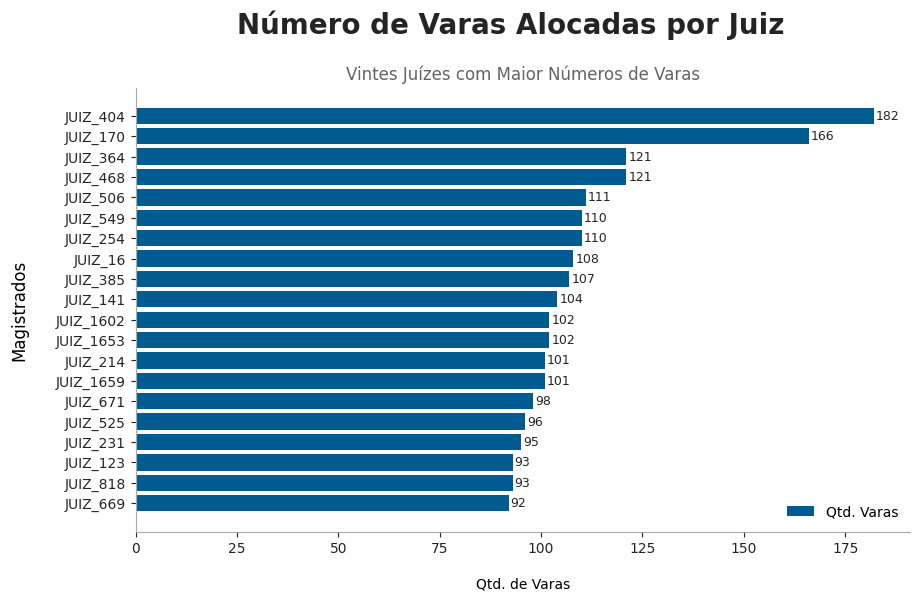

In [ ]:
# Gr√°fico da aloca√ß√£o do n√∫mero de varas por juiz
plt.style.use('default')

# Cria objeto para o plot
fig, ax = plt.subplots(figsize=(10,6))
fig.subplots_adjust(top=0.85)
# Titulos e subtitulos
fig.suptitle('N√∫mero de Varas Alocadas por Juiz', fontweight='bold', fontsize=20, color=cinza3)
ax.set_title('Vintes Ju√≠zes com Maior N√∫meros de Varas', y=1, color=cinza2)
ax.set_ylabel('Magistrados', labelpad=20, fontsize=12)
ax.set_xlabel("\nQtd. de Varas")

# Retiea bordas dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Muda cor dos eixos
ax.spines['left'].set_color(cinza1)
ax.spines['bottom'].set_color(cinza1)

# Eixo Y (nomes)
#y = range(len(df_juiz_x_vara))
qtd_ref = 20
y = range(qtd_ref)
# Linha central no zero
ax.axvline(0, color=cinza1)

# Barras
ax.barh(y, df_juiz_x_vara.iloc[0:qtd_ref, 1].sort_values(), color=tjba_azul, label="Qtd. Varas", height=0.8)

# Ajusta os ticks do eixo Y
ax.set_yticks(y)
ax.set_yticklabels(df_juiz_x_vara.iloc[0:qtd_ref, 0])
# Aumentar o tamanho da fonte das marcas no eixo X
ax.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax.tick_params(axis='y', labelsize=10, colors=cinza3)
# Coloca legenda
ax.legend(edgecolor='none')

# Adiciona os valores nas barras
for i, v in enumerate(df_juiz_x_vara.iloc[0:qtd_ref, 1].sort_values()):
    ax.text(v + 0.5, i, str(v), va='center', ha='left', color=cinza3, fontsize=9)

#plt.tight_layout()
plt.show()

In [40]:
# Gerando df com produtividade das varas vs n√∫mero de ju√≠zes alocados
df_demanda_vara_x_juize = df_processos[['vara_str']].drop_duplicates().reset_index(drop=True)

df_demanda_vara_x_juize['prod_antes'] = df_demanda_vara_x_juize['vara_str'].map(
    df_processos.groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

df_demanda_vara_x_juize['qtd_juiz'] = df_demanda_vara_x_juize['vara_str'].map(
    df_processos.groupby('vara_str')['juiz_str'].nunique()
).fillna(0)

df_demanda_vara_x_juize

vara_str  prod_antes  qtd_juiz
0     VARA_11534       27446        40
1     VARA_11453      267994        25
2     VARA_11369       16650        22
3     VARA_11483       39058        77
4      VARA_1124       17496        19
..           ...         ...       ...
845  VARA_111163           4         1
846  VARA_111123           4         1
847   VARA_11944           4         1
848   VARA_11937           8         1
849  VARA_111081           4         1

[850 rows x 3 columns]

In [ ]:
# Gr√°fico da produtividade das varas vs n√∫mero de ju√≠zes
chart = (
    alt.Chart(df_demanda_vara_x_juize)
    .mark_circle(size=100, opacity=0.5, color="steelblue")
    .encode(
        x=alt.X(
            "qtd_juiz", 
            title="Qtd. de Ju√≠zes", 
            axis=alt.Axis(
                grid=False,
                titleFontSize=18,
                titlePadding=20,
                labelFontSize=14
            )
        ), 
        y=alt.Y(
            "prod_antes", 
            title="Produtividade da Vara", 
            axis=alt.Axis(
                grid=False,
                titleFontSize=18,
                titlePadding=20,
                labelFontSize=14
            )
        ),
        tooltip=["qtd_juiz", "prod_antes", "vara_str"]
    ).properties(
        width=600,   # largura do gr√°fico
        height=400,   # altura do gr√°fico
        title={
            "text": "Produtividade - √ìg√£o Jugador",
            "subtitle": ["Produtividade Vara VS N√∫mero de Ju√≠zes"],
            #"anchor": "start",      # alinhar √† esquerda
            "fontSize": 20,
            "subtitleFontSize": 14,
            "subtitlePadding": 15
        }
    )
)
chart


alt.Chart(...)

# Modelo

**O Objetivo Principal**

O objetivo central do modelo √© encontrar a **aloca√ß√£o √≥tima de ju√≠zes para as varas**, visando maximizar a efici√™ncia e o equil√≠brio na distribui√ß√£o da carga de trabalho em todo o 1¬∫ Grau.

Em vez de focar diretamente em aumentar o n√∫mero de processos julgados, o modelo trabalha na organiza√ß√£o da for√ßa de trabalho. Ele utiliza a produtividade hist√≥rica de cada magistrado como uma medida de sua capacidade de trabalho e busca alocar essa capacidade da maneira mais inteligente poss√≠vel. A meta √© direcionar os recursos para onde a demanda real de processos √© mais cr√≠tica, resultando em um sistema mais equilibrado e com maior potencial de vaz√£o.

Em termos pr√°ticos, a l√≥gica do modelo busca o seguinte:

> "Encontre a melhor maneira de distribuir as fra√ß√µes da capacidade de trabalho de todos os ju√≠zes entre todas as varas, de tal forma que, ao somarmos a produtividade de cada juiz multiplicada pela fra√ß√£o de sua aloca√ß√£o, o resultado total seja o maior poss√≠vel. O objetivo √© posicionar os ju√≠zes, especialmente os mais produtivos, onde eles possam contribuir ao m√°ximo para a capacidade geral do tribunal de lidar com seu volume de processos, sempre respeitando as regras do sistema (as restri√ß√µes)."

Em suma, o modelo n√£o visa simplesmente inflar uma m√©trica, mas sim redesenhar a organiza√ß√£o do trabalho para que o sistema como um todo opere com maior fluidez, equil√≠brio e potencial para dar vaz√£o ao seu volume real de processos.

## Funcionamento

O modelo de otimiza√ß√£o foi projetado para operar como uma "fotografia" do sistema judici√°rio. Ele analisa o estado do tribunal em um per√≠odo de tempo espec√≠fico e fixo (seja um trimestre ou um ano inteiro) e determina a melhor aloca√ß√£o de recursos para aquele cen√°rio.

O mecanismo central √© um processo de designa√ß√£o: para um per√≠odo escolhido, o modelo recebe um conjunto de recursos  **ju√≠zes com suas capacidades produtivas** ( $P_{i,t}$ ), **experi√™ncias** ( $E_{i,k}$ ) e um conjunto de necessidades, varas com suas **demandas** e **limites operacionais** ( $D_{j,k,t}$, $C_{j,t}$ e $M_{j,t}$ ). Sua fun√ß√£o √© determinar a maneira mais eficiente de designar esses recursos para atender √†s necessidades, maximizando a aplica√ß√£o da capacidade produtiva total do sistema.

**A Import√¢ncia da Produtividade Ponderada (Pesos)**

Uma caracter√≠stica fundamental do modelo √© o uso de pesos para medir tanto a produtividade dos ju√≠zes quanto a demanda das varas, em vez de usar a simples quantidade de processos. Essa abordagem √© vantajosa por duas raz√µes principais:

*   **Reflete a Complexidade:** Reconhece que nem todo processo exige o mesmo esfor√ßo. Um caso complexo n√£o pode ser comparado a um processo simples em termos de carga de trabalho. O peso quantifica essa diferen√ßa.

*   **Aloca√ß√£o Mais Justa:** Permite que o modelo aloque ju√≠zes considerando n√£o apenas quantos processos eles podem julgar, mas tamb√©m a dificuldade desses processos. Isso leva a uma distribui√ß√£o de trabalho mais equitativa e realista.

**Formula√ß√£o para um Per√≠odo Fixo**

A estrutura matem√°tica do modelo reflete essa abordagem de "fotografia":

*   As vari√°veis de decis√£o $x_{i,j}$ representam a fra√ß√£o de aloca√ß√£o de um juiz a uma vara neste per√≠odo, n√£o ao longo do tempo.
*   Os par√¢metros $P_{i,t}$, $D_{j,k,t}$, $C_{j,t}$ e $M_{j,t}$ embora possuam um √≠ndice de tempo (t), s√£o "congelados" para o per√≠odo de refer√™ncia escolhido (ex: T4 de 2024 ou o ano de 2024).
*   As restri√ß√µes s√£o aplicadas sobre essa "fotografia", garantindo que a aloca√ß√£o proposta seja vi√°vel para aquele cen√°rio espec√≠fico.
<br></br>

> Dessa forma, o modelo oferece uma recomenda√ß√£o otimizada e customizada para a realidade do per√≠odo analisado, seja para responder √†s condi√ß√µes mais recentes (an√°lise trimestral) ou para um planejamento estrat√©gico de longo prazo (an√°lise anual).

## Conjuntos

$$I: \text{ Conjunto de todos os ju√≠zes dispon√≠veis para aloca√ß√£o. Cada juiz } i \in I \text{ √© um elemento √∫nico}$$

$$ \text{Exemplo: } I = \{ \text{Juiz}_1, \ \text{Juiz}_2, \ \dots, \ \text{Juiz}_n \}$$

$$J: \text{ Conjunto de todas as varas do 1¬∫ Grau. Cada vara } j \in J \text{ √© uma unidade de destino para aloca√ß√£o de ju√≠zes} $$

$$ \text{Exemplo: } J = \{ \text{Vara}_1, \ \text{Vara}_2, \ \dots, \ \text{Vara}_n \}$$

$$K: \text{Conjunto de todas as compet√™ncias das varas (e, consequentemente, das especializa√ß√µes dos ju√≠zes). Cada compet√™ncia } k \in K \text{ representa uma √°rea do direito.}$$

$$ \text{Exemplo: } K = \{ \text{C√≠vel, Criminal, Fazenda P√∫blica, Fam√≠lia, ...} \}$$

## Par√¢metros



( $P_{i,t}$ ) -  Produtividade ponderada do juiz no per√≠odo $i \in I, \text{no per√≠odo } t$. Representa a soma dos pesos dos processos julgados pelo juiz $i$ no trimestre $t$. Este par√¢metro √© crucial para medir a capacidade de trabalho real de cada magistrado.

In [42]:
# Gerando df com produtividade de magistrados (P_it)
P_it = df_processos[['juiz_str']].drop_duplicates().reset_index(drop=True)

# Criando produtivedade ponderada para 1¬∫ trimestre
P_it['t1'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 2¬∫ trimestre
P_it['t2'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 3¬∫ trimestre
P_it['t3'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando produtivedade ponderada para 4¬∫ trimestre
P_it['t4'] = P_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Produtividade ponderada para o ano
P_it['ano'] = P_it['juiz_str'].map(
    df_processos.groupby('juiz_str')['pje_vl_peso_processual'].sum()
).fillna(0)

P_it

juiz_str     t1     t2     t3     t4     ano
0     JUIZ_378   7148   6334   7760   6104   27346
1     JUIZ_166  27900  58404  99336  85590  271230
2     JUIZ_649   9906  13678  13460  11028   48072
3     JUIZ_599   5564   6044   4992   3474   20074
4    JUIZ_1638   3604   5088   5362   5058   19112
..         ...    ...    ...    ...    ...     ...
619   JUIZ_337      4      0      4      0       8
620   JUIZ_224     20      0     24      0      44
621   JUIZ_793     28      4      8      0      40
622   JUIZ_502      0      0      0     32      32
623   JUIZ_205      0      8     12      0      20

[624 rows x 6 columns]

( $E_{k,i}$ ) - Par√¢metro bin√°rio que indica se o juiz $i \in I$  possui experi√™ncia $k \in K.E_{i,k} = 1$ se o juiz tem a compet√™ncia $k$, e $0$ caso contr√°rio. A experi√™ncia √© fundamental para garantir que os ju√≠zes sejam alocados a varas onde sua expertise √© relevante.

In [43]:
# Gerando df com compet√™ncias atuanyes dos magistrados (E_ik)
E_ik = df_processos[['juiz_str']].drop_duplicates().reset_index(drop=True)
naturezas = df_processos[['vm_competencia']].drop_duplicates().reset_index(drop=True)
E_ik = E_ik.merge(naturezas, how='cross')

E_ik = E_ik.merge(
    df_processos[['juiz_str', 'vm_competencia']].drop_duplicates(),
    on=['juiz_str', 'vm_competencia'],
    how='left',
    indicator=True
)

E_ik['flag'] = (E_ik['_merge'] == 'both').astype(int)
E_ik = E_ik.drop(columns=['_merge'], axis=1)

E_ik

juiz_str                          vm_competencia  flag
0      JUIZ_378    FAZENDA PUBLICA ATOS ADMINISTRATIVOS     1
1      JUIZ_378                FAZENDA PUBLICA TRIBUTOS     1
2      JUIZ_378                                 FAMILIA     1
3      JUIZ_378                     RELACOES DE CONSUMO     1
4      JUIZ_378                   ACIDENTES DO TRABALHO     1
...         ...                                     ...   ...
63643  JUIZ_205              EXECUCOES RECESSO SALVADOR     0
63644  JUIZ_205          [CEJUSC PREPROCESSUAL] ZONA IV     0
63645  JUIZ_205  [CEJUSC PREPROCESSUAL FAMILIA] ZONA 18     0
63646  JUIZ_205               CRIMINAL RECESSO SALVADOR     0
63647  JUIZ_205                       CEJUSC_FAZENDARIO     0

[63648 rows x 3 columns]

( $C_{j,t}$ ) - Capacidade m√°xima ponderada da vara $j \in J, \text{no per√≠odo } t$. Representa o volume m√°ximo de processos (em pontos) que a vara $j$ demonstrou ser capaz de julgar no trimestre $t$. Este par√¢metro atua como um limite superior para a carga de trabalho que uma vara pode absorver.

In [44]:
# Gerando df com produtividade das varas (C_jt)
C_jt = df_processos[['vara_str', 'vm_vara']].drop_duplicates().reset_index(drop=True)

# Criando capacidade ponderada para 1¬∫ trimestre
C_jt['t1'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 2¬∫ trimestre
C_jt['t2'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 3¬∫ trimestre
C_jt['t3'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para 4¬∫ trimestre
C_jt['t4'] = C_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

# Criando capacidade ponderada para o ano
C_jt['ano'] = C_jt['vara_str'].map(
    df_processos.groupby('vara_str')['pje_vl_peso_processual'].sum()
).fillna(0)

C_jt

vara_str                                               vm_vara     t1  \
0     VARA_11534  2¬™ VARA DE FEITOS DE REL DE CONS. C√çVEL E COMERCIAIS   7284   
1     VARA_11453                            2¬™ VARA DA FAZENDA P√öBLICA  27884   
2     VARA_11369  1¬™ VARA DE FEITOS DE REL DE CONS. C√çVEL E COMERCIAIS    892   
3     VARA_11483                        2¬™ VARA DE RELACOES DE CONSUMO   9954   
4      VARA_1124                                            VARA C√çVEL   2584   
..           ...                                                   ...    ...   
845  VARA_111163                                 VARA JURISDI√á√ÉO PLENA      4   
846  VARA_111123                                 VARA JURISDI√á√ÉO PLENA      0   
847   VARA_11944                        VARA RECESSO CIVEL DE GUANAMBI      4   
848   VARA_11937                      VARA RECESSO CIVEL DE ALAGOINHAS      0   
849  VARA_111081                                 VARA JURISDICAO PLENA      0   

        t2     t3     t4     ano  
0     6174   7880   6108   27446  
1    58388  97180  84542  267994  
2     4294   7144   4320   16650  
3    12160   9636   7308   39058  
4     3832   4654   6426   17496  
..     ...    ...    ...     ...  
845      0      0      0       4  
846      0      0      4       4  
847      0      0      0       4  
848      0      0      8       8  
849      0      0      4       4  

[850 rows x 7 columns]

( $D_{j,k,t}$ ) - Demanda ponderada de processos para a vara $j \in J \text{ na compet√™ncia } k \in K \text{ no per√≠odo } t$. Representa a soma dos pesos dos processos que chegam √† vara $j \text{ com a compet√™ncia } k \text{ no trimestre } t$. Este par√¢metro reflete a necessidade de trabalho de cada vara, segmentada por especializa√ß√£o.

In [45]:
# Gerando df com produtividade das varas/compet√™ncia (D_jkt)
D_jkt = df_processos.groupby(['vara_str', 'vm_competencia'], as_index=False) \
    .agg({'pje_vl_peso_processual': 'sum'}) \
    .rename(columns={'pje_vl_peso_processual': 'ano'})

# Produtividade das varas/compet√™ncia para 1¬∫ trimestre
t1 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/compet√™ncia para 2¬∫ trimestre
t2 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/compet√™ncia para 3¬∫ trimestre
t3 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Produtividade das varas/compet√™ncia para 4¬∫ trimestre
t4 = (
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby(['vara_str', 'vm_competencia'])['pje_vl_peso_processual'].sum()
)

# Alinhar usando join no √≠ndice
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t1.rename("t1")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t2.rename("t2")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t3.rename("t3")).fillna(0).reset_index()
D_jkt = D_jkt.set_index(['vara_str', 'vm_competencia']).join(t4.rename("t4")).fillna(0).reset_index()

D_jkt

vara_str             vm_competencia  ano  t1  t2  t3  t4
0     VARA_111005  CRIMINAL RECESSO INTERIOR   12   0   0   0  12
1     VARA_111006  CRIMINAL RECESSO INTERIOR    8   4   0   0   4
2     VARA_111017     CIVEL RECESSO INTERIOR    4   0   0   0   4
3     VARA_111021     CIVEL RECESSO INTERIOR    4   0   0   0   4
4     VARA_111026     CIVEL RECESSO INTERIOR   20  20   0   0   0
...           ...                        ...  ...  ..  ..  ..  ..
4684   VARA_11974          PLANTAO UNIFICADO    4   0   0   0   4
4685   VARA_11976  CRIMINAL RECESSO INTERIOR    8   0   0   0   8
4686   VARA_11976          PLANTAO UNIFICADO    4   0   0   0   4
4687   VARA_11989  CRIMINAL RECESSO INTERIOR   12  12   0   0   0
4688   VARA_11992  CRIMINAL RECESSO INTERIOR    8   0   0   0   8

[4689 rows x 7 columns]

( $M_{j,t}$ ) - N√∫mero m√°ximo de ju√≠zes que podem ser alocados √† vara $j \in J \text{ no per√≠odo } t$. Este par√¢metro representa uma estimativa da capacidade m√°xima da vara baseada no maior n√∫mero de ju√≠zes que atuaram nela durante os trimestres de 2024.

O total representa quantos ju√≠zes diferentes passaram pela vara ao longo do ano, n√£o o m√°ximo simult√¢neo. Para o modelo de otimiza√ß√£o, faz mais sentido usar o maior valor trimestral como capacidade m√°xima:

In [46]:
# Gerando df com quantidade de magistrados por vara (M_jt)
M_jt = (
    df_processos.groupby(['vara_str', 'vm_vara'])['vm_magistrado']
    .nunique().reset_index(name='ano')
)

# Quantidade de ju√≠zes primeiro trimestre
M_jt['t1'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de ju√≠zes segundo trimestre
M_jt['t2'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de ju√≠zes terceiro trimestre
M_jt['t3'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

# Quantidade de ju√≠zes quarto trimestre
M_jt['t4'] = M_jt['vara_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('vara_str')['juiz_str'].nunique()
).fillna(0).astype(int)

M_jt

vara_str  \
0    VARA_111005   
1    VARA_111006   
2    VARA_111017   
3    VARA_111021   
4    VARA_111026   
..           ...   
845   VARA_11971   
846   VARA_11974   
847   VARA_11976   
848   VARA_11989   
849   VARA_11992   

                                                                      vm_vara  \
0                                              VARA RECESSO CIVEL DE SERRINHA   
1                                                                  VARA CRIME   
2    1¬™ VARA DOS FEITOS RELATIVOS √ÄS RELA√á√ïES DE CONSUMO, C√çVEIS E COMERCIAIS   
3                                                                  VARA C√çVEL   
4                                                                  VARA C√çVEL   
..                                                                        ...   
845                                                                VARA CRIME   
846                                                          1¬™ VARA CRIMINAL   
847                                                                VARA CRIME   
848                                                                VARA CRIME   
849                                                                VARA CRIME   

     ano  t1  t2  t3  t4  
0      3   0   0   0   3  
1      2   1   0   0   1  
2      1   0   0   0   1  
3      1   0   0   0   1  
4      1   1   0   0   0  
..   ...  ..  ..  ..  ..  
845    2   1   0   0   1  
846    1   0   0   0   1  
847    1   0   0   0   1  
848    3   3   0   0   0  
849    2   0   0   0   2  

[850 rows x 7 columns]

( $N_{i,t}$ ) - N√∫mero de varas distintas em que o juiz $i \in I \text{ j√° atuou no per√≠odo } t$. Esta informa√ß√£o √© valiosa para an√°lises adicionais e para entender a flexibilidade ou a experi√™ncia de cada juiz ao longo do tempo. Pode ser incorporada em restri√ß√µes mais avan√ßadas (ex: prefer√™ncia por ju√≠zes com maior $N_{i,t}$ para varas com alta variabilidade de demanda, ou como um custo de realoca√ß√£o para ju√≠zes com baixo $N_{i,t}$).

In [47]:
# Gerando df com quantidade des varas que cada juiz atuou por trimestre (N_it)
N_it = df_processos.groupby('juiz_str')['vara_str'].nunique().reset_index() \
    .sort_values('vara_str', ascending=False).reset_index(drop=True)

N_it.columns = ['juiz_str', 'ano']

# Primeiro trimestre
N_it['t1'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 1]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Segundo trimestre
N_it['t2'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 2]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Terceiro trimestre
N_it['t3'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 3]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

# Quarto trimestre
N_it['t4'] = N_it['juiz_str'].map(
    df_processos[df_processos['vm_dt_movimento'].dt.quarter == 4]
    .groupby('juiz_str')['vara_str'].nunique()
).fillna(0).astype(int)

N_it

juiz_str  ano  t1  t2   t3  t4
0     JUIZ_669  182  68  98  100  56
1     JUIZ_818  166  49  39   96  53
2     JUIZ_123  121  57  59   51  65
3     JUIZ_231  121  62  69   66  45
4     JUIZ_525  111  62  52   59  59
..         ...  ...  ..  ..  ...  ..
619    JUIZ_14    4   4   0    0   0
620   JUIZ_195    3   3   0    0   0
621  JUIZ_1627    3   3   0    0   0
622  JUIZ_1614    2   2   0    0   0
623   JUIZ_337    1   1   0    1   0

[624 rows x 6 columns]

## Modelagem

In [48]:
# Verifica a quantidade de CPUs dispon√≠veis
nucleos_disponiveis = os.cpu_count()
print(f"N√∫cleos dispon√≠veis: {nucleos_disponiveis}")

# Definimos qual trimestre ser√° usado para a otimiza√ß√£o
PERIODO_REFERENCIA = 'ano' 
print(f"Per√≠odo de refer√™ncia para otimiza√ß√£o: {PERIODO_REFERENCIA}")

N√∫cleos dispon√≠veis: 10
Per√≠odo de refer√™ncia para otimiza√ß√£o: ano


In [49]:
# CONVERS√ÉO DOS DATAFRAMES PARA DICION√ÅRIOS
# O Pyomo trabalha melhor com dicion√°rios para par√¢metros indexados

# Produtividade dos Ju√≠zes (P_it)
produtividade_juizes = dict(zip(P_it['juiz_str'], P_it[PERIODO_REFERENCIA].values.tolist()))
print(f"Produtividade de ju√≠zes: {len(produtividade_juizes)} registros")

# Especializa√ß√£o dos Ju√≠zes (E_ik)
especializacao_juizes = dict(zip(zip(E_ik['juiz_str'], E_ik['vm_competencia']), E_ik['flag']))
print(f"Especializa√ß√£o de ju√≠zes: {len(especializacao_juizes)} registros")

# Capacidade das Varas (C_jt)
capacidade_varas = dict(zip(C_jt['vara_str'], C_jt[PERIODO_REFERENCIA].values.tolist()))
print(f"Capacidade de varas: {len(capacidade_varas)} registros")

# Demanda por Vara e Natureza (D_jkt)
demanda_varas = dict(zip(zip(D_jkt['vara_str'], D_jkt['vm_competencia']), D_jkt[PERIODO_REFERENCIA].values.tolist()))
print(f"Demanda de varas: {len(demanda_varas)} registros")

# M√°ximo de Ju√≠zes por Vara (M_jt)
if PERIODO_REFERENCIA == 'ano':
    max_juizes_vara = dict(zip(M_jt['vara_str'], M_jt[PERIODO_REFERENCIA].values.tolist()))
else:
    max_juizes_vara = dict(zip(M_jt['vara_str'], M_jt[['t1', 't2', 't3', 't4']].max(axis=1)))
print(f"M√°ximo de ju√≠zes por vara: {len(max_juizes_vara)} registros")

Produtividade de ju√≠zes: 624 registros
Especializa√ß√£o de ju√≠zes: 63648 registros
Capacidade de varas: 850 registros
Demanda de varas: 4689 registros
M√°ximo de ju√≠zes por vara: 850 registros


In [50]:
# Conjuntos √∫nicos que ser√£o usados no modelo

# Conjunto de Ju√≠zes (I)
juizes = P_it['juiz_str'].tolist()
print(f"N√∫mero de ju√≠zes: {len(juizes)}")

# Conjunto de Varas (J)
varas = C_jt['vara_str'].tolist()
print(f"N√∫mero de varas: {len(varas)}")

# Conjunto de Compet√™ncias (K)
competencia = E_ik['vm_competencia'].unique().tolist()
print(f"N√∫mero de compet√™ncia: {len(competencia)}")

# Verificamos se todos os ju√≠zes t√™m produtividade
juizes_sem_produtividade = [j for j in juizes if j not in produtividade_juizes]
if juizes_sem_produtividade:
    print(f"ATEN√á√ÉO: {len(juizes_sem_produtividade)} ju√≠zes sem dados de produtividade")

# Verificamos se todas as varas t√™m capacidade
varas_sem_capacidade = [v for v in varas if v not in capacidade_varas]
if varas_sem_capacidade:
    print(f"ATEN√á√ÉO: {len(varas_sem_capacidade)} varas sem dados de capacidade")

N√∫mero de ju√≠zes: 624
N√∫mero de varas: 850
N√∫mero de compet√™ncia: 102


In [51]:
# ConcreteModel = modelo onde os dados s√£o fornecidos diretamente na cria√ß√£o
# √â um 'container' que vai armazenar todos os componentes do problema
# Conjuntos (Sets), Par√¢metros, Vari√°veis, Restri√ß√µes e Fun√ß√£o Objetivo
modelo = pyo.ConcreteModel()

# DEFINI√á√ÉO DE CONJUNTOS (SETS)

# Conjunto I: Ju√≠zes
modelo.I = pyo.Set(initialize=juizes)
print(f"‚úì Conjunto I (Ju√≠zes) criado: {len(modelo.I)} elementos")

# Conjunto J: Varas
modelo.J = pyo.Set(initialize=varas)
print(f"‚úì Conjunto J (Varas) criado: {len(modelo.J)} elementos")

# Conjunto K: Compet√™ncias
modelo.K = pyo.Set(initialize=competencia)
print(f"‚úì Conjunto K (Compet√™ncias) criado: {len(modelo.K)} elementos")
print(f"‚úì Total de combina√ß√µes (i,j): {len(modelo.I) * len(modelo.J)}")
print(f"‚úì Total de combina√ß√µes (j,k): {len(modelo.J) * len(modelo.K)}")

‚úì Conjunto I (Ju√≠zes) criado: 624 elementos
‚úì Conjunto J (Varas) criado: 850 elementos
‚úì Conjunto K (Compet√™ncias) criado: 102 elementos
‚úì Total de combina√ß√µes (i,j): 530400
‚úì Total de combina√ß√µes (j,k): 86700


In [52]:
# DEFINI√á√ÉO DOS PAR√ÇMETROS (PARAMETERS)

# Par√¢metro P[i]: Produtividade ponderada do juiz i
# Na matem√°tica: P_i ‚àà ‚Ñù‚Å∫ para todo i ‚àà I
# No Pyomo: modelo.P indexado pelo conjunto I
modelo.P = pyo.Param(modelo.I, initialize=produtividade_juizes)
print(f"‚úì Par√¢metro P[i] (Produtividade dos Ju√≠zes) criado, {len(modelo.P)} valores de produtividade")

# Par√¢metro C[j]: Capacidade m√°xima da vara j
# Na matem√°tica: C_j ‚àà ‚Ñù‚Å∫ para todo j ‚àà J
# No Pyomo: modelo.C indexado pelo conjunto J
modelo.C = pyo.Param(modelo.J, initialize=capacidade_varas)
print(f"‚úì Par√¢metro C[j] (Capacidade das Varas) criado, {len(modelo.C)} valores de capacidade")

# Par√¢metro D[j,k]: Demanda da vara j para compet√™ncia k
# Na matem√°tica: D_{j,k} ‚àà ‚Ñù‚Å∫ para todo j ‚àà J, k ‚àà K
# No Pyomo: modelo.D indexado pelos conjuntos J e K
# Usamos default=0 para combina√ß√µes que n√£o existem nos dados
modelo.D = pyo.Param(modelo.J, modelo.K, initialize=demanda_varas, default=0)
print(f"‚úì Par√¢metro D[j,k] (Demanda por Vara e Compet√™ncia) criado, {len(modelo.J) * len(modelo.K)} combina√ß√µes poss√≠veis")

# Par√¢metro E[i,k]: Especializa√ß√£o do juiz i na compet√™ncia k
# Na matem√°tica: E_{i,k} ‚àà {0,1} para todo i ‚àà I, k ‚àà K
# No Pyomo: modelo.E indexado pelos conjuntos I e K
# Usamos default=0 para combina√ß√µes que n√£o existem nos dados
modelo.E = pyo.Param(modelo.I, modelo.K, initialize=especializacao_juizes, default=0)
print(f"‚úì Par√¢metro E[i,k] (Especializa√ß√£o dos Ju√≠zes) criado, {len(modelo.I) * len(modelo.K)} combina√ß√µes poss√≠veis")

# Par√¢metro M[j]: M√°ximo de ju√≠zes que podem ser alocados √† vara j
# Na matem√°tica: M_j ‚àà ‚Ñï para todo j ‚àà J
# No Pyomo: modelo.M indexado pelo conjunto J
modelo.M = pyo.Param(modelo.J, initialize=max_juizes_vara)
print(f"‚úì Par√¢metro M[j] (M√°ximo de Ju√≠zes por Vara) criado, {len(modelo.M)} valores de m√°ximo")

‚úì Par√¢metro P[i] (Produtividade dos Ju√≠zes) criado, 624 valores de produtividade
‚úì Par√¢metro C[j] (Capacidade das Varas) criado, 850 valores de capacidade
‚úì Par√¢metro D[j,k] (Demanda por Vara e Compet√™ncia) criado, 86700 combina√ß√µes poss√≠veis
‚úì Par√¢metro E[i,k] (Especializa√ß√£o dos Ju√≠zes) criado, 63648 combina√ß√µes poss√≠veis
‚úì Par√¢metro M[j] (M√°ximo de Ju√≠zes por Vara) criado, 850 valores de m√°ximo


In [53]:
# DEFINI√á√ÉO DAS VARI√ÅVEIS DE DECIS√ÉO (VARIABLES)

# Vari√°vel x[i,j]: Fra√ß√£o da capacidade produtiva do juiz i alocada √† vara j
# Na matem√°tica: x_{i,j} ‚àà [0,1] para todo i ‚àà I, j ‚àà J
# No Pyomo: modelo.x indexado pelos conjuntos I e J
modelo.x = pyo.Var(modelo.I, modelo.J, domain=pyo.NonNegativeReals, bounds=(0, 1))
print(f"‚úì Vari√°vel x[i,j] (Aloca√ß√£o de Ju√≠zes √†s Varas) criada")
print(f"   - Tipo: Cont√≠nua")
print(f"   - Dom√≠nio: [0, 1] (fra√ß√£o da capacidade)")
print(f"   - Total de vari√°veis: {len(modelo.I) * len(modelo.J)}")

‚úì Vari√°vel x[i,j] (Aloca√ß√£o de Ju√≠zes √†s Varas) criada
   - Tipo: Cont√≠nua
   - Dom√≠nio: [0, 1] (fra√ß√£o da capacidade)
   - Total de vari√°veis: 530400


In [54]:
# DEFINI√á√ÉO DA FUN√á√ÉO OBJETIVO (OBJECTIVE)

# Fun√ß√£o Objetivo: Maximizar a produtividade ponderada total
# Na matem√°tica: max Œ£·µ¢ Œ£‚±º P_i √ó x_{i,j}
# No Pyomo: Objective com sense=maximize
modelo.obj = pyo.Objective(
    expr=sum(modelo.P[i] * modelo.x[i, j] for i in modelo.I for j in modelo.J),
    sense=pyo.maximize
)

print(f"‚úì Fun√ß√£o Objetivo criada")
print(f"   - Tipo: Maximiza√ß√£o")
print(f"   - Express√£o: Œ£·µ¢ Œ£‚±º P[i] √ó x[i,j]")
print(f"   ‚úì Vari√°veis envolvidas: {len(modelo.I) * len(modelo.J)} vari√°veis x[i,j]")
print(f"   ‚úì Par√¢metros envolvidos: {len(modelo.P)} valores de produtividade P[i]")

‚úì Fun√ß√£o Objetivo criada
   - Tipo: Maximiza√ß√£o
   - Express√£o: Œ£·µ¢ Œ£‚±º P[i] √ó x[i,j]
   ‚úì Vari√°veis envolvidas: 530400 vari√°veis x[i,j]
   ‚úì Par√¢metros envolvidos: 624 valores de produtividade P[i]


In [55]:
# RESTRI√á√ÉO 1: Capacidade dos Ju√≠zes
# Na matem√°tica: Œ£‚±º x_{i,j} ‚â§ 1 ‚àÄ i ‚àà I
# Significado: A soma das aloca√ß√µes de um juiz n√£o pode exceder 100% de sua capacidade
modelo.restricao_capacidade_juizes = pyo.Constraint(
    modelo.I,
    rule=lambda modelo, i: sum(modelo.x[i, j] for j in modelo.J) <= 1
)
print("‚úì Restri√ß√£o 1: Capacidade dos Ju√≠zes")
print("   - Œ£‚±º x[i,j] ‚â§ 1 para todo juiz i")
print("   - Garante que um juiz n√£o seja alocado com mais de 100% de sua capacidade")

# RESTRI√á√ÉO 2: Especializa√ß√£o dos Ju√≠zes
# Na matem√°tica: x_{i,j} ‚â§ Œ£‚Çñ E_{i,k} √ó (D_{j,k} > 0) ‚àÄ i ‚àà I, j ‚àà J
# Significado: Um juiz s√≥ pode ser alocado a uma vara se for especializado em pelo menos uma das compet√™ncias que a vara atende
# Implementa√ß√£o simplificada: se o juiz n√£o tem especializa√ß√£o em nenhuma natureza que a vara atende, x[i,j] = 0
def regra_especializacao(modelo, i, j):
    # Verifica se o juiz i tem especializa√ß√£o em alguma natureza que a vara j atende
    tem_especializacao = False
    for k in modelo.K:
        if modelo.D[j, k] > 0 and modelo.E[i, k] == 1:  # Vara j atende natureza k E juiz i √© especializado em k
            tem_especializacao = True
            break
    
    if tem_especializacao:
        return pyo.Constraint.Skip  # N√£o aplica restri√ß√£o (juiz pode ser alocado)
    else:
        return modelo.x[i, j] == 0  # Juiz n√£o pode ser alocado a esta vara

modelo.restricao_especializacao = pyo.Constraint(
    modelo.I, modelo.J,
    rule=regra_especializacao
)
print("‚úì Restri√ß√£o 2: Especializa√ß√£o dos Ju√≠zes")
print("   - x[i,j] = 0 se juiz i n√£o tem especializa√ß√£o em nenhuma natureza que vara j atende")
print("   - Garante que ju√≠zes s√≥ sejam alocados onde t√™m compet√™ncia")

# RESTRI√á√ÉO 3: Capacidade das Varas
# Na matem√°tica: Œ£·µ¢ P_i √ó x_{i,j} ‚â§ C_j ‚àÄ j ‚àà J
# Significado: A produtividade total alocada a uma vara n√£o pode exceder sua capacidade
modelo.restricao_capacidade_varas = pyo.Constraint(
    modelo.J,
    rule=lambda modelo, j: sum(modelo.P[i] * modelo.x[i, j] for i in modelo.I) <= modelo.C[j]
)
print("‚úì Restri√ß√£o 3: Capacidade das Varas")
print("   - Œ£·µ¢ P[i] √ó x[i,j] ‚â§ C[j] para toda vara j")
print("   - Garante que a carga de trabalho de uma vara n√£o exceda sua capacidade")

# RESTRI√á√ÉO 4: Atendimento √† Demanda
# Na matem√°tica: Œ£·µ¢ P_{i,t} √ó x_{i,j} √ó E_{i,k} ‚â• D_{j,k,t} ‚àÄj ‚àà J, k ‚àà K
# Significado: A capacidade de julgamento para a natureza k na vara j deve ser maior ou igual √† demanda
modelo.restricao_atendimento_demanda = pyo.Constraint(
    modelo.J, modelo.K,
    rule=lambda modelo, j, k: sum(modelo.P[i] * modelo.x[i, j] * modelo.E[i, k] 
                                for i in modelo.I) >= modelo.D[j, k]
)
print("‚úì Restri√ß√£o 4: Atendimento √† Demanda")
print("   - Œ£·µ¢ P[i] √ó x[i,j] √ó E[i,k] ‚â• D[j,k] para toda vara j e natureza k")
print("   - Garante que a demanda de cada vara por natureza seja atendida por ju√≠zes especializados")

# RESTRI√á√ÉO 5: M√°ximo de Ju√≠zes por Vara
# Na matem√°tica: Œ£·µ¢ x_{i,j} ‚â§ M_j ‚àÄ j ‚àà J
# Significado: O n√∫mero total de ju√≠zes (fra√ß√µes) alocados a uma vara n√£o pode exceder o m√°ximo
modelo.restricao_max_juizes_vara = pyo.Constraint(
    modelo.J,
    rule=lambda modelo, j: sum(modelo.x[i, j] for i in modelo.I) <= modelo.M[j]
)
print("‚úì Restri√ß√£o 5: M√°ximo de Ju√≠zes por Vara")
print("   - Œ£·µ¢ x[i,j] ‚â§ M[j] para toda vara j")
print("   - Garante que uma vara n√£o tenha mais ju√≠zes do que pode comportar")

‚úì Restri√ß√£o 1: Capacidade dos Ju√≠zes
   - Œ£‚±º x[i,j] ‚â§ 1 para todo juiz i
   - Garante que um juiz n√£o seja alocado com mais de 100% de sua capacidade
‚úì Restri√ß√£o 2: Especializa√ß√£o dos Ju√≠zes
   - x[i,j] = 0 se juiz i n√£o tem especializa√ß√£o em nenhuma natureza que vara j atende
   - Garante que ju√≠zes s√≥ sejam alocados onde t√™m compet√™ncia
‚úì Restri√ß√£o 3: Capacidade das Varas
   - Œ£·µ¢ P[i] √ó x[i,j] ‚â§ C[j] para toda vara j
   - Garante que a carga de trabalho de uma vara n√£o exceda sua capacidade
‚úì Restri√ß√£o 4: Atendimento √† Demanda
   - Œ£·µ¢ P[i] √ó x[i,j] √ó E[i,k] ‚â• D[j,k] para toda vara j e natureza k
   - Garante que a demanda de cada vara por natureza seja atendida por ju√≠zes especializados
‚úì Restri√ß√£o 5: M√°ximo de Ju√≠zes por Vara
   - Œ£·µ¢ x[i,j] ‚â§ M[j] para toda vara j
   - Garante que uma vara n√£o tenha mais ju√≠zes do que pode comportar


In [56]:
# Cria√ß√£o e execu√ß√£o do solver
try:
    # Configura√ß√µes b√°sicas do HiGHS
    print("üîß CONFIGURANDO SOLVER:")
    
    # 'appsi_highs': Interface moderna do HiGHS (recomendada)
    # 'highs': Interface cl√°ssica do HiGHS (alternativa)
    solver = pyo.SolverFactory('appsi_highs')
    print("   ‚úÖ Objeto solver criado com sucesso!")
        
    if solver.available():        
        # Configurar tempo limite (em segundos)
        solver.config.time_limit = 3600 
        print("   ‚è±Ô∏è Tempo limite: 3600 segundos (1 hora)")
        
        # Configurar toler√¢ncia de otimalidade
        solver.config.mip_gap = 1e-6  # 0.0001%
        print("   üéØ Gap de otimalidade: 1e-6 (0.0001%)")
            
        # Configurar verbosidade (0=silencioso, 1=normal, 2=detalhado)
        solver.config.log_level = 1
        print("   üì¢ N√≠vel de log: 1 (normal)")
        print("   ‚úÖ Op√ß√µes configuradas com sucesso!")
    else:
        print("   ‚ùå N√£o foi poss√≠vel criar o objeto solver.")
        solver = None
except Exception as e:
    print(f"   ‚ùå Erro ao criar solver: {e}")
    solver = None
else:
    try:
        # Resolver o modelo
        print("\nüîÑ EXECUTANDO SOLVER HiGHS...")
        resultado = solver.solve(modelo, tee=True)  # tee=True mostra log do solver
        print("   ‚úÖ Resolu√ß√£o conclu√≠da!")
    except Exception as e:
        print(f"‚ùå Erro durante a resolu√ß√£o: {e}")
        exit(1)

üîß CONFIGURANDO SOLVER:
   ‚úÖ Objeto solver criado com sucesso!
   ‚è±Ô∏è Tempo limite: 3600 segundos (1 hora)
   üéØ Gap de otimalidade: 1e-6 (0.0001%)
   üì¢ N√≠vel de log: 1 (normal)
   ‚úÖ Op√ß√µes configuradas com sucesso!

üîÑ EXECUTANDO SOLVER HiGHS...
   ‚úÖ Resolu√ß√£o conclu√≠da!


# Resultados

In [57]:
print("üîç AN√ÅLISE DO RESULTADO:")
print()

# Verificar status de termina√ß√£o
status_terminacao = resultado.solver.termination_condition
print(f"üìã Status de termina√ß√£o: {status_terminacao}")

# Interpretar o status
if status_terminacao == pyo.TerminationCondition.optimal:
    print("   ‚úÖ SOLU√á√ÉO √ìTIMA ENCONTRADA!")
    print("   üéØ O solver encontrou a melhor solu√ß√£o poss√≠vel")
    print("   üìà Todos os crit√©rios de otimalidade foram satisfeitos")
    
elif status_terminacao == pyo.TerminationCondition.feasible:
    print("   ‚ö†Ô∏è SOLU√á√ÉO VI√ÅVEL ENCONTRADA (mas pode n√£o ser √≥tima)")
    print("   üìä O solver encontrou uma solu√ß√£o v√°lida")
    print("   ‚è∞ Pode ter parado por limite de tempo ou gap")
    
elif status_terminacao == pyo.TerminationCondition.infeasible:
    print("   ‚ùå PROBLEMA INVI√ÅVEL!")
    print("   üö´ N√£o existe solu√ß√£o que satisfa√ßa todas as restri√ß√µes")
    print("   üîß Verifique se as restri√ß√µes s√£o muito restritivas")
    
elif status_terminacao == pyo.TerminationCondition.unbounded:
    print("   ‚ö†Ô∏è PROBLEMA ILIMITADO!")
    print("   üìà A fun√ß√£o objetivo pode crescer infinitamente")
    print("   üîß Verifique se faltam restri√ß√µes importantes")
    
elif status_terminacao == pyo.TerminationCondition.maxTimeLimit:
    print("   ‚è∞ LIMITE DE TEMPO ATINGIDO!")
    print("   üìä Solver parou por limite de tempo (3600s)")
    print("   üí° Solu√ß√£o atual pode ser boa, mas n√£o garantidamente √≥tima")
    
else:
    print(f"   ‚ùì STATUS DESCONHECIDO: {status_terminacao}")

print()

# Verificar se temos uma solu√ß√£o utiliz√°vel
if status_terminacao in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible]:
    print("üéâ TEMOS UMA SOLU√á√ÉO UTILIZ√ÅVEL!")
    
    # Extrair valor da fun√ß√£o objetivo
    try:
        valor_objetivo = pyo.value(modelo.obj)
        print(f"   üéØ Valor da fun√ß√£o objetivo: {valor_objetivo:.2f} pontos")
        print(f"   üìä Produtividade total otimizada: {valor_objetivo:.2f}")
        
        # Verificar quantas vari√°veis s√£o n√£o-zero
        variaveis_ativas = 0
        for i in modelo.I:
            for j in modelo.J:
                if pyo.value(modelo.x[i, j]) > 1e-6:  # Considera > 0.000001 como ativo
                    variaveis_ativas += 1
        
        print(f"   üìà Aloca√ß√µes ativas: {variaveis_ativas} de {len(modelo.I) * len(modelo.J)} poss√≠veis")
        
    except Exception as e:
        print(f"   ‚ö†Ô∏è Erro ao extrair valor objetivo: {e}")
        
else:
    print("‚ùå N√ÉO TEMOS UMA SOLU√á√ÉO UTILIZ√ÅVEL!")

üîç AN√ÅLISE DO RESULTADO:

üìã Status de termina√ß√£o: optimal
   ‚úÖ SOLU√á√ÉO √ìTIMA ENCONTRADA!
   üéØ O solver encontrou a melhor solu√ß√£o poss√≠vel
   üìà Todos os crit√©rios de otimalidade foram satisfeitos

üéâ TEMOS UMA SOLU√á√ÉO UTILIZ√ÅVEL!
   üéØ Valor da fun√ß√£o objetivo: 11482812.00 pontos
   üìä Produtividade total otimizada: 11482812.00
   üìà Aloca√ß√µes ativas: 2072 de 530400 poss√≠veis


In [58]:
# Percorre e demostra todas aloca√ß√µes feita pelo modelo
#for (i, j) in modelo.x:
#    print(f"x[{i},{j}] = {modelo.x[i,j].value}")

In [59]:
def identificar_alocacao_juizes(modelo) -> list:
    """
    Identifica quais ju√≠zes foram ou n√£o alocados a uma ou mais varas.
    """
    juizes_nao_alocados = []
    juizes_alocados = []
    
    for i in modelo.I:
        soma_alocacao = sum(pyo.value(modelo.x[i, j]) for j in modelo.J)
        
        if soma_alocacao < 1e-6:  # Praticamente zero
            juizes_nao_alocados.append(i)
        else:
            juizes_alocados.append({
                'juiz': i,
                'soma_alocacao': soma_alocacao
            })
    
    return juizes_nao_alocados, juizes_alocados

juizes_nao_alocados, juizes_alocados = identificar_alocacao_juizes(modelo)

print(f'De um total de {len(juizes_nao_alocados) + len(juizes_alocados)} ju√≠zes, ' 
    f'{len(juizes_alocados)} foram alocados e {len(juizes_nao_alocados)} n√£o foram alocados pelo modelo.')

De um total de 624 ju√≠zes, 624 foram alocados e 0 n√£o foram alocados pelo modelo.


In [60]:
def identificar_alocacao_varas(modelo) -> list:
    """
    Identifica quais varas tiveram ou n√£o a aloca√ß√£o de ju√≠zes.
    """
    varas_com_juizes = []
    varas_sem_juizes = []

    for j in modelo.J:
        soma_vara = sum(pyo.value(modelo.x[i, j]) for i in modelo.I)

        if soma_vara < 1e-6:
            varas_sem_juizes.append(j)
        else:
            varas_com_juizes.append({
                'vara': j,
                'soma_alocacao': soma_vara
            })

    return varas_sem_juizes, varas_com_juizes

varas_sem_juizes, varas_com_juizes = identificar_alocacao_varas(modelo)

print(f'De um total de {len(varas_sem_juizes) + len(varas_com_juizes)} varas, ' 
    f'{len(varas_com_juizes)} tiveram ju√≠zes alocados nas varas e {len(varas_sem_juizes)} varas n√£o receberam a aloca√ß√£o de ju√≠zes.')

De um total de 850 varas, 850 tiveram ju√≠zes alocados nas varas e 0 varas n√£o receberam a aloca√ß√£o de ju√≠zes.


In [61]:
# Executar somente em casos de ju√≠zes n√£o alocados, verifica demanda de ju√≠zes e varas n√£o alocadas pelo modelo
ci = P_it[P_it['juiz_str'].isin(juizes_nao_alocados)][[PERIODO_REFERENCIA]].sum()[0]
cv = D_jkt[D_jkt['vara_str'].isin(varas_sem_juizes)][[PERIODO_REFERENCIA]].sum()[0]

if ci == 0:
    print(f'Os Ju√≠zes n√£o alocados, n√£o tiveram demanda no per√≠odo {PERIODO_REFERENCIA}')
if cv == 0:
    print(f'As Varas n√£o alocadas, n√£o possuem demanda no per√≠odo {PERIODO_REFERENCIA}')


Os Ju√≠zes n√£o alocados, n√£o tiveram demanda no per√≠odo ano
As Varas n√£o alocadas, n√£o possuem demanda no per√≠odo ano


In [62]:
# Criando df com aloca√ß√£o de ju√≠zes, baseado no resultado do modelo
dados_xij = []

for i in modelo.I:
    for j in modelo.J:
        if modelo.x[i, j].value > 1e-6:     # ou if pyo.value(modelo.x[i, j]) > 1e-6:
            valor = modelo.x[i, j].value
            dados_xij.append({'juiz': i, 'vara': j, 'valor': valor, 'percentual': valor * 100})
            #print(f"x[{i},{j}] = {modelo.x[i,j].value}")
            
df_alocacoes = pd.DataFrame(dados_xij).sort_values('valor', ascending=False).reset_index(drop=True)

df_alocacoes

juiz         vara     valor  percentual
0      JUIZ_378   VARA_11452  1.000000  100.000000
1      JUIZ_102   VARA_11220  1.000000  100.000000
2      JUIZ_572  VARA_111343  1.000000  100.000000
3      JUIZ_243   VARA_11470  1.000000  100.000000
4     JUIZ_1329   VARA_11552  1.000000  100.000000
...         ...          ...       ...         ...
2067   JUIZ_642   VARA_11521  0.000031    0.003053
2068   JUIZ_488   VARA_11461  0.000029    0.002861
2069   JUIZ_161   VARA_11946  0.000023    0.002326
2070   JUIZ_161  VARA_111017  0.000023    0.002326
2071   JUIZ_161   VARA_11954  0.000023    0.002326

[2072 rows x 4 columns]

In [63]:
def analisar_por_juiz(df_alocacoes) -> pd.DataFrame:
    """
    Analisa as aloca√ß√µes agrupadas por juiz.
    """
    # Agrupar por juiz
    analise_juiz = df_alocacoes.groupby('juiz').agg({
        'valor': ['count', 'sum'],
        'percentual': ['sum']
    }).round(2)
    
    # Simplificar nomes das colunas
    analise_juiz.columns = ['num_varas', 'soma_fracao', 'percentual_total']
    
    # Ordenar por percentual total decrescente
    analise_juiz = analise_juiz.sort_values('percentual_total', ascending=False)
    
    return analise_juiz

df_analises_juizes = analisar_por_juiz(df_alocacoes)

df_analises_juizes

num_varas  soma_fracao  percentual_total
juiz                                               
JUIZ_10            3          1.0             100.0
JUIZ_475           7          1.0             100.0
JUIZ_466           1          1.0             100.0
JUIZ_467           1          1.0             100.0
JUIZ_468           1          1.0             100.0
...              ...          ...               ...
JUIZ_1681          1          1.0             100.0
JUIZ_169           6          1.0             100.0
JUIZ_170           1          1.0             100.0
JUIZ_171           7          1.0             100.0
JUIZ_99            1          1.0             100.0

[624 rows x 3 columns]

In [64]:
# Verificando se algum juiz foi alocado com menos de 100%
df_analises_juizes[df_analises_juizes['soma_fracao'] != 1.0]

Empty DataFrame
Columns: [num_varas, soma_fracao, percentual_total]
Index: []

In [65]:
def analisar_produtividade_alocados(modelo, juizes_alocados):
    """
    Analisa a produtividade dos ju√≠zes alocados
    """
    print("üìà PRODUTIVIDADE DOS JU√çZES ALOCADOS:")
    
    produtividades = []
    for juiz in juizes_alocados:
        prod = pyo.value(modelo.P[juiz['juiz']])
        produtividades.append({
            'juiz': juiz['juiz'],
            'produtividade': prod
        })
    
    # Ordenar por produtividade
    produtividades.sort(key=lambda x: x['produtividade'], reverse=True)
    
    print(f"   üìä Total de ju√≠zes alocados: {len(produtividades)}")
    
    if len(produtividades) > 0:
        prods = [p['produtividade'] for p in produtividades]
        print(f"   üìà Maior produtividade: {max(prods):.2f}")
        print(f"   üìâ Menor produtividade: {min(prods):.2f}")
        print(f"   üìä Produtividade m√©dia: {sum(prods)/len(prods):.2f}\n")
        
        print(f"   üèÜ Top 10 alocados por produtividade:")
        for i, item in enumerate(produtividades[:10]):
            print(f"      {i+1}. {item['juiz']}: {item['produtividade']:.2f}")
    
    return produtividades

produtividades_alocados = analisar_produtividade_alocados(modelo, juizes_alocados)

üìà PRODUTIVIDADE DOS JU√çZES ALOCADOS:
   üìä Total de ju√≠zes alocados: 624
   üìà Maior produtividade: 271230.00
   üìâ Menor produtividade: 8.00
   üìä Produtividade m√©dia: 18401.94

   üèÜ Top 10 alocados por produtividade:
      1. JUIZ_166: 271230.00
      2. JUIZ_146: 217674.00
      3. JUIZ_161: 171980.00
      4. JUIZ_453: 145864.00
      5. JUIZ_488: 139834.00
      6. JUIZ_503: 122120.00
      7. JUIZ_204: 113180.00
      8. JUIZ_84: 113036.00
      9. JUIZ_213: 107350.00
      10. JUIZ_399: 102674.00


In [66]:
# Criando df de compara√ß√£o do n√©mero de varas por juiz, antes e depois
juiz_x_vara = (
    df_alocacoes.groupby('juiz')['vara']
    .nunique()
    .reset_index()
    .sort_values('vara', ascending=False)
)

juiz_x_vara.columns = ['Juiz', 'Aloc. Vara (depois)']

juiz_x_vara['Aloc. Vara (antes)'] = juiz_x_vara['Juiz'].map(
    N_it.set_index('juiz_str')[PERIODO_REFERENCIA]
)

#juiz_x_vara.sort_values(['Aloc. Vara (antes)'], ascending=False, inplace=True)

juiz_x_vara

Juiz  Aloc. Vara (depois)  Aloc. Vara (antes)
465  JUIZ_525                   32                 111
148  JUIZ_161                   22                  35
239  JUIZ_213                   16                  30
433  JUIZ_488                   15                  31
369  JUIZ_399                   14                  38
..        ...                  ...                 ...
425  JUIZ_480                    1                  16
426  JUIZ_481                    1                  17
429  JUIZ_484                    1                  14
430  JUIZ_485                    1                  19
623   JUIZ_99                    1                  33

[624 rows x 3 columns]

In [67]:
juiz_x_vara.describe()

Aloc. Vara (depois)  Aloc. Vara (antes)
count           624.000000          624.000000
mean              3.320513           39.177885
std               2.935885           23.553949
min               1.000000            1.000000
25%               1.000000           23.000000
50%               2.000000           34.000000
75%               4.000000           51.000000
max              32.000000          182.000000

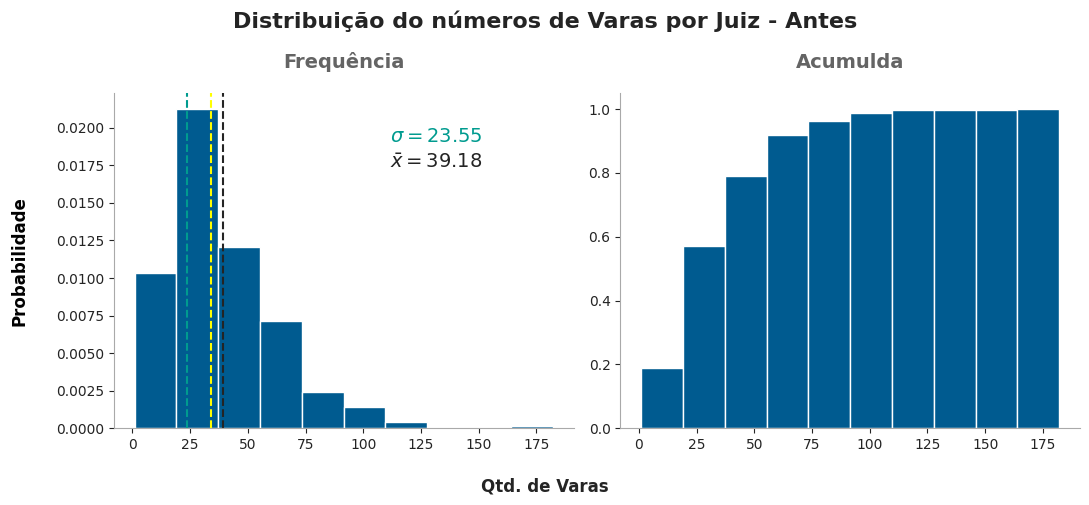

In [68]:
# Gr√°fico da distribui√ß√£o do n√∫mero de varas por juiz (antes)
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Distribui√ß√£o do n√∫meros de Varas por Juiz - Antes', fontweight='bold', fontsize=16, color=cinza3)
fig.subplots_adjust(top=0.80)

ax1.set_title('Frequ√™ncia', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax1.set_ylabel('Probabilidade', fontweight='bold', labelpad=20, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(cinza1)
ax1.spines['bottom'].set_color(cinza1)
ax1.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax1.tick_params(axis='y', labelsize=10, colors=cinza3)
n, bins, patches = ax1.hist(juiz_x_vara['Aloc. Vara (antes)'], density=True, edgecolor='white', color=tjba_azul)
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].mean(), color=cinza3, linestyle='--', label='M√©dia')
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].median(), color="yellow", linestyle='--', label='Mediana')
ax1.axvline(juiz_x_vara['Aloc. Vara (antes)'].std(), color=tjba_verde, linestyle='--', label='Desvio Padr√£o')
ax1.text(0.6, 0.90, rf"$\sigma = {juiz_x_vara['Aloc. Vara (antes)'].std():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=tjba_verde)
ax1.text(0.6, 0.82, rf"$\bar{{x}} = {juiz_x_vara['Aloc. Vara (antes)'].mean():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=cinza3)

ax2.set_title('Acumulda', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(cinza1)
ax2.spines['bottom'].set_color(cinza1)
ax2.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax2.tick_params(axis='y', labelsize=10, colors=cinza3)
ax2.hist(juiz_x_vara['Aloc. Vara (antes)'], density=True, cumulative=True, edgecolor='white', color=tjba_azul)

fig.supxlabel('Qtd. de Varas', fontweight='bold', fontsize=12, color=cinza3, y=0.01) 

plt.tight_layout()
plt.show()

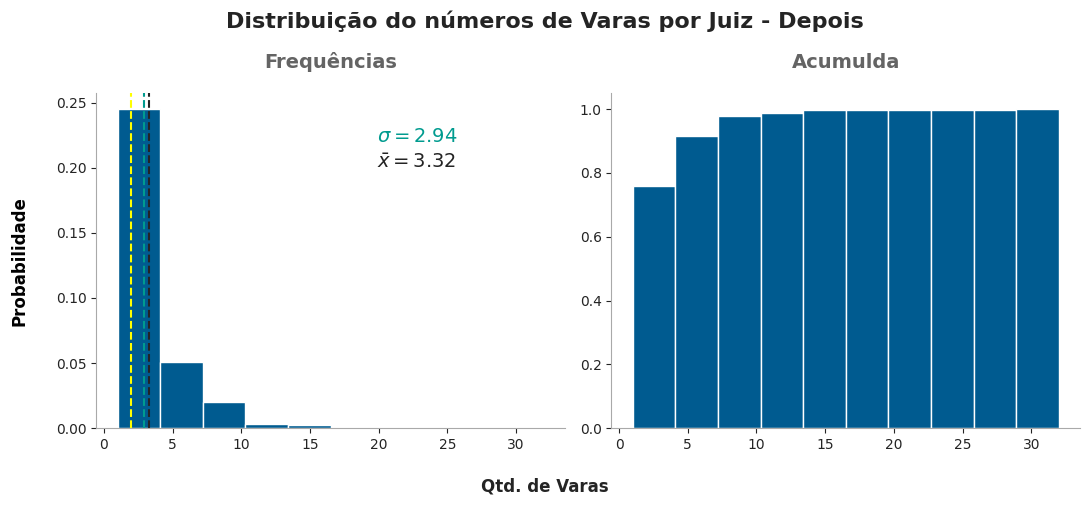

In [69]:
# Gr√°fico da distribui√ß√£o do n√∫mero de varas por juiz (depois)
fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Distribui√ß√£o do n√∫meros de Varas por Juiz - Depois', fontweight='bold', fontsize=16, color=cinza3)
fig.subplots_adjust(top=0.80)

ax1.set_title('Frequ√™ncias', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax1.set_ylabel('Probabilidade', fontweight='bold', labelpad=20, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(cinza1)
ax1.spines['bottom'].set_color(cinza1)
ax1.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax1.tick_params(axis='y', labelsize=10, colors=cinza3)
n, bins, patches = ax1.hist(juiz_x_vara['Aloc. Vara (depois)'], density=True, edgecolor='white', color=tjba_azul)
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].mean(), color=cinza3, linestyle='--', label='M√©dia')
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].median(), color="yellow", linestyle='--', label='Mediana')
ax1.axvline(juiz_x_vara['Aloc. Vara (depois)'].std(), color=tjba_verde, linestyle='--', label='Desvio Padr√£o')
ax1.text(0.6, 0.90, rf"$\sigma = {juiz_x_vara['Aloc. Vara (depois)'].std():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=tjba_verde)
ax1.text(0.6, 0.82, rf"$\bar{{x}} = {juiz_x_vara['Aloc. Vara (depois)'].mean():.2f}$", 
        transform=ax1.transAxes, fontsize=14, va="top", color=cinza3)

ax2.set_title('Acumulda', fontweight='bold', fontsize=14, y=1.05, color=cinza2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(cinza1)
ax2.spines['bottom'].set_color(cinza1)
ax2.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax2.tick_params(axis='y', labelsize=10, colors=cinza3)
ax2.hist(juiz_x_vara['Aloc. Vara (depois)'], density=True, cumulative=True, edgecolor='white', color=tjba_azul)

fig.supxlabel('Qtd. de Varas', fontweight='bold', fontsize=12, color=cinza3, y=0.01) 

plt.tight_layout()
plt.show()

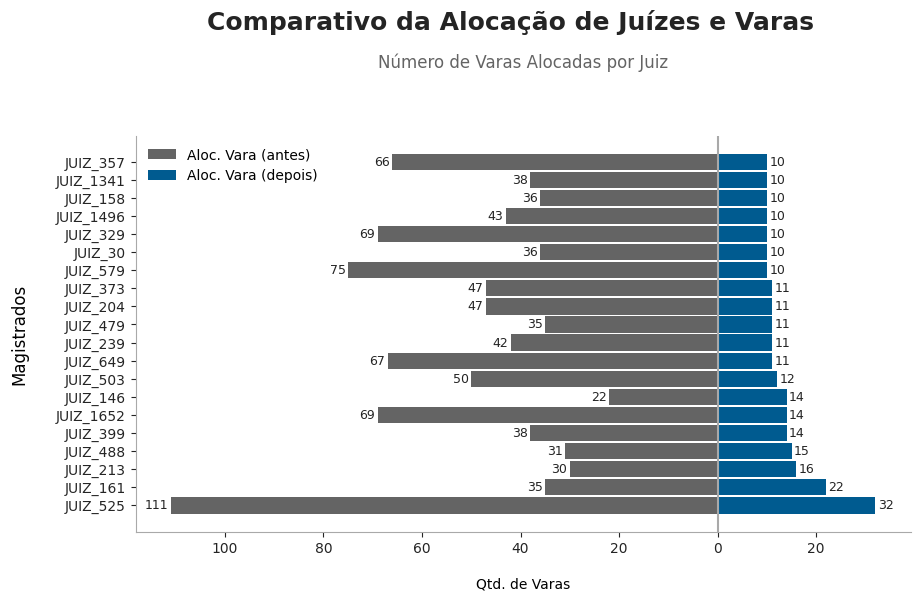

In [70]:
# Gr√°fico compartivo da aloca√ß√£o de ju√≠zes e varas
plt.style.use('default')

# Cria objeto para o plot
fig, ax = plt.subplots(figsize=(10,6))
fig.subplots_adjust(top=0.77)
# Titulos e subtitulos
fig.suptitle('Comparativo da Aloca√ß√£o de Ju√≠zes e Varas', fontweight='bold', fontsize=18, color=cinza3)
ax.set_title('N√∫mero de Varas Alocadas por Juiz', y=1.15, color=cinza2)
ax.set_ylabel('Magistrados', labelpad=20, fontsize=12)
ax.set_xlabel("\nQtd. de Varas")
#
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{abs(x):g}"))

# Retiea bordas dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Muda cor dos eixos
ax.spines['left'].set_color(cinza1)
ax.spines['bottom'].set_color(cinza1)

# Eixo Y (nomes)
#y = range(len(juiz_x_vara))
qtd_ref = 20
y = range(20)
# Linha central no zero
ax.axvline(0, color=cinza1)

# Barras
ax.barh(y, -juiz_x_vara.iloc[0:qtd_ref, 2], color=cinza2, label="Aloc. Vara (antes)", height=0.9)
ax.barh(y, juiz_x_vara.iloc[0:qtd_ref, 1], color=tjba_azul, label="Aloc. Vara (depois)", height=0.9)

# Ajusta os ticks do eixo Y
ax.set_yticks(y)
ax.set_yticklabels(juiz_x_vara.iloc[0:qtd_ref, 0])
# Aumentar o tamanho da fonte das marcas no eixo X
ax.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax.tick_params(axis='y', labelsize=10, colors=cinza3)

# Coloca legenda
ax.legend(edgecolor='none')

# Adiciona os valores nas barras (antes - esquerda)
for i, v in enumerate(juiz_x_vara.iloc[0:qtd_ref, 2]):
    ax.text(-v - 0.5, i, str(v), va='center', ha='right', color=cinza3, fontsize=9)

# Adiciona os valores nas barras (depois - direita)
for i, v in enumerate(juiz_x_vara.iloc[0:qtd_ref, 1]):
    ax.text(v + 0.5, i, str(v), va='center', ha='left', color=cinza3, fontsize=9)

#plt.tight_layout()
plt.show()

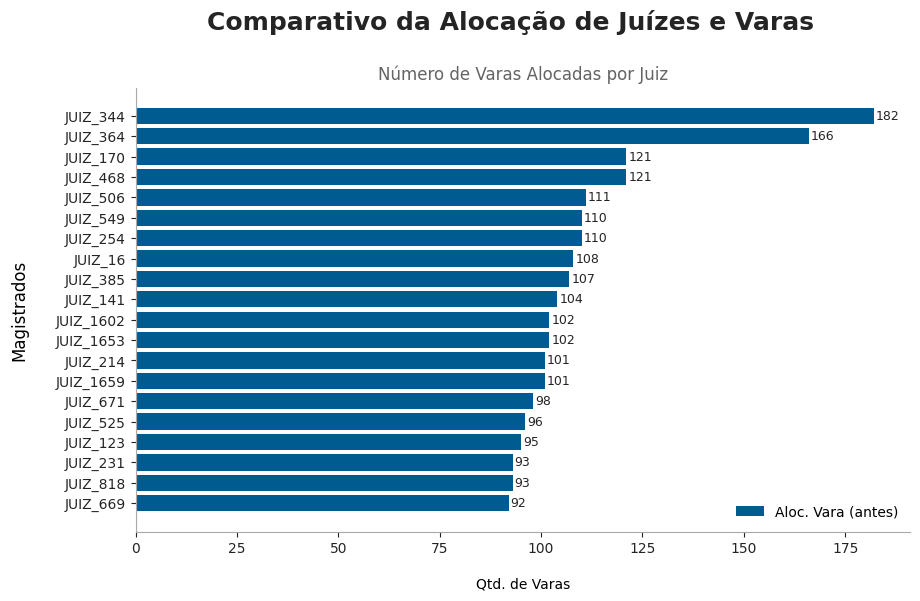

In [71]:
juiz_x_vara_sort_antes = juiz_x_vara.sort_values(['Aloc. Vara (antes)'], ascending=False)

# Gr√°fico compartivo da aloca√ß√£o de ju√≠zes e varas
plt.style.use('default')

# Cria objeto para o plot
fig, ax = plt.subplots(figsize=(10,6))
fig.subplots_adjust(top=0.85)
# Titulos e subtitulos
fig.suptitle('Comparativo da Aloca√ß√£o de Ju√≠zes e Varas', fontweight='bold', fontsize=18, color=cinza3)
ax.set_title('N√∫mero de Varas Alocadas por Juiz', y=1, color=cinza2)
ax.set_ylabel('Magistrados', labelpad=20, fontsize=12)
ax.set_xlabel("\nQtd. de Varas")

# Retiea bordas dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Muda cor dos eixos
ax.spines['left'].set_color(cinza1)
ax.spines['bottom'].set_color(cinza1)

# Eixo Y (nomes)
#y = range(len(juiz_x_vara_sort_antes))
qtd_ref = 20
y = range(qtd_ref)
# Linha central no zero
ax.axvline(0, color=cinza1)

# Barras
ax.barh(y, juiz_x_vara_sort_antes.iloc[0:qtd_ref, 2].sort_values(), color=tjba_azul, label="Aloc. Vara (antes)", height=0.8)

# Ajusta os ticks do eixo Y
ax.set_yticks(y)
ax.set_yticklabels(juiz_x_vara_sort_antes.iloc[0:qtd_ref, 0])
# Aumentar o tamanho da fonte das marcas no eixo X
ax.tick_params(axis='x', labelsize=10, colors=cinza3)  
ax.tick_params(axis='y', labelsize=10, colors=cinza3)
# Coloca legenda
ax.legend(edgecolor='none')

# Adiciona os valores nas barras
for i, v in enumerate(juiz_x_vara_sort_antes.iloc[0:qtd_ref, 2].sort_values()):
    ax.text(v + 0.5, i, str(v), va='center', ha='left', color=cinza3, fontsize=9)

#plt.tight_layout()
plt.show()

## Conclus√£o

O fato do modelo ter encontrado uma solu√ß√£o √≥tima significa que o **modelo conseguiu alocar 100% da capacidade produtiva de todos os ju√≠zes dispon√≠veis sem violar nenhuma das restri√ß√µes do sistema**.

**Ent√£o, onde est√° o 'ganho' do modelo?**

O ganho n√£o est√° em "criar" mais produtividade do que a existente, o que √© imposs√≠vel. O ganho est√° em provar que √© poss√≠vel atingir a produtividade m√°xima de uma forma mais organizada, equilibrada e eficiente do que a forma como ela est√° distribu√≠da atualmente.

A **"m√°gica"** do modelo n√£o est√° no valor final da Fun√ß√£o Objetivo (neste caso), mas na nova configura√ß√£o das vari√°veis $x_{i,j}$ **(a distribui√ß√£o de ju√≠zes nas varas)**. A solu√ß√£o √≥tima do modelo, apesar de ter o mesmo valor de produtividade total, representa uma aloca√ß√£o superior por v√°rias raz√µes:

* **Atendimento √† Demanda:** A aloca√ß√£o hist√≥rica (a real) pode n√£o estar atendendo √† demanda espec√≠fica de cada vara. A sua nova distribui√ß√£o garante que a produtividade alocada para cada especialidade na vara seja suficiente para cobrir a demanda ponderada ( $D_{j,k,t}$ ). A aloca√ß√£o anterior provavelmente n√£o cumpria isso em todas as varas.

* **Respeito √† Capacidade da Vara:** Historicamente, algumas varas podem estar sobrecarregadas, com uma carga de trabalho total maior do que sua capacidade ( $C_{j,t}$ ). O modelo moveu ju√≠zes para garantir que a produtividade total alocada a uma vara n√£o exceda sua capacidade m√°xima.

* **Equil√≠brio da Carga de Trabalho:** O resultado pr√°tico do ponto anterior √© um sistema mais equilibrado. O modelo provavelmente tirou "press√£o" de varas superlotadas e utilizou a capacidade de varas que estavam ociosas, promovendo um equil√≠brio mais justo na carga de trabalho.

* **Aloca√ß√£o Correta por Especializa√ß√£o:** O modelo garantiu que 100% das aloca√ß√µes respeitassem a especializa√ß√£o do juiz. Na pr√°tica, a aloca√ß√£o hist√≥rica pode ter tido inconsist√™ncias que a sua solu√ß√£o √≥tima corrigiu.

* **Respeito aos Limites F√≠sicos:** A sua solu√ß√£o garante que nenhuma vara tenha mais ju√≠zes do que o seu m√°ximo hist√≥rico ( $M_{j,t}$ ).

O modelo provou que √© poss√≠vel manter a produtividade m√°xima do sistema (utilizar 100% da for√ßa de trabalho dos ju√≠zes) e, ao mesmo tempo, organizar a distribui√ß√£o dessa for√ßa de trabalho para respeitar todas as regras operacionais e demandas do judici√°rio. O valor do modelo n√£o est√° no aumento da produtividade (pois ela j√° estava no teto), mas a otimiza√ß√£o da distribui√ß√£o, gerando mais equil√≠brio e efici√™ncia operacional. 